In [1]:
import pandas as pd
import torch
import json
import os
import argparse
import random
import pickle
import numpy as np
from collections import defaultdict
from operator import itemgetter
from scipy.stats import rankdata
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import gzip
from pprint import pprint
from scipy.stats import ttest_ind
from sklearn.cluster.bicluster import SpectralCoclustering
from sklearn.cluster import KMeans
from sklearn import manifold


import data
import data_config

import warnings
warnings.filterwarnings("ignore")

/Users/hedi/.conda/envs/pytorch/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.cluster.bicluster module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
sns.set(rc={'figure.figsize':(15,10)})
sns.set(font_scale=1.5)
sns.set_style('whitegrid', {'font.family':'serif', 'font.serif':'Times New Roman'})


In [3]:
def reverse_rankdata(a):
    return rankdata([-1 * i for i in a]).astype(int)

def generate_p_val(a, b):
    t, p = ttest_ind(a, b, equal_var=False)
    print("ttest_ind:            t = %g  p = %g" % (t, p))

## Ablation Study 

In [4]:
def build_ablation_plot_df(mean_val_df, drug_list, pdtc_flag=False, by='adsn_norm'):
    method_dict = {
               'ndsn':"code-ae-base*", 
               'mdsn': 'code-ae-mmd*', 
               'adsn': 'code-ae-adv*',
               'ndsn_concat':"code-ae-base(concat)*", 
               'mdsn_concat': 'code-ae-mmd(concat)*', 
               'adsn_concat': 'code-ae-adv(concat)*',
               'ndsn_norm_concat':"code-ae-base(concat)", 
               'mdsn_norm_concat': 'code-ae-mmd(concat)', 
               'adsn_norm_concat': 'code-ae-adv(concat)',
               'ndsn_norm':"code-ae-base", 
               'mdsn_norm': 'code-ae-mmd', 
               'adsn_norm': 'code-ae-adv'
              }
    if pdtc_flag:
        drug_mapping_df = pd.read_csv(data_config.gdsc_pdtc_drug_name_mapping_file, index_col=0)
    else:
        drug_mapping_df = pd.read_csv(data_config.gdsc_tcga_mapping_file, index_col=0)
        
    drug_dict = drug_mapping_df['gdsc_name'].to_dict()
    
    mean_val_df = mean_val_df[drug_list]
    drug_order = mean_val_df.transpose().sort_values(by, ascending=False).index.to_list()
    drug_order = [drug_dict[drug] for drug in drug_order]
    
    mean_val_df = mean_val_df.rename(index=method_dict)
    mean_val_df = mean_val_df.rename(index={k: k.upper() for k in mean_val_df.index})
    mean_val_df = mean_val_df.rename(columns=drug_dict)
    mean_val_df = mean_val_df.stack().rename('mean_val')
        
    plot_df = mean_val_df.to_frame().reset_index().rename(columns={'level_0':'method', 'level_1':'drug'})
    plot_df['normalization'] = ['NO' if flag else 'YES' for flag in plot_df.method.str.contains('\*')]
    plot_df.loc[plot_df.normalization == 'NO', 'method'] = plot_df.loc[plot_df.normalization == 'NO', 'method'].str[:-1]

            
    method_order = ['CODE-AE-ADV','CODE-AE-ADV(CONCAT)', 'CODE-AE-BASE','CODE-AE-BASE(CONCAT)','CODE-AE-MMD','CODE-AE-MMD(CONCAT)']
    plot_df.method = plot_df.method.astype('category')
    plot_df.method.cat.set_categories(method_order, inplace=True)
    plot_df.sort_values(by='method', inplace=True)
    
    plot_df.drug = plot_df.drug.astype('category')
    plot_df.drug.cat.set_categories(drug_order, inplace=True)
    plot_df.sort_values(by='drug', inplace=True)


    
    return plot_df

    

In [5]:
pdtc_drug_list = pd.read_csv(data_config.gdsc_pdtc_drug_name_mapping_file, index_col=0).index.tolist()
pdtc_auc_ft_report = pd.read_csv('../intermediate_results/plot_data/ablation_pdtc_auc_ft_mean.csv', index_col=0)
pdtc_auc_ft_report_std = pd.read_csv('../intermediate_results/plot_data/ablation_pdtc_auc_ft_std.csv',index_col=0)
ablation_pdtc_plot_df = build_ablation_plot_df(mean_val_df=pdtc_auc_ft_report,
                             drug_list = pdtc_drug_list,
                             pdtc_flag=True,
                             by='adsn_norm'
)

In [6]:
pdtc_auc_ft_report.apply(reverse_rankdata, axis=0).mean(axis=1)

method
ndsn                9.02
mdsn                6.32
adsn                3.80
ndsn_norm           6.34
mdsn_norm           7.08
adsn_norm           1.70
ndsn_concat         9.20
mdsn_concat         6.90
adsn_concat         4.40
ndsn_norm_concat    7.52
mdsn_norm_concat    8.70
adsn_norm_concat    6.50
dtype: float64

In [7]:
pdtc_auc_ft_report.apply(reverse_rankdata, axis=0).std(axis=1)

method
ndsn                2.217647
mdsn                2.645288
adsn                2.222336
ndsn_norm           3.255200
mdsn_norm           3.911469
adsn_norm           1.265718
ndsn_concat         2.515260
mdsn_concat         2.501020
adsn_concat         2.579353
ndsn_norm_concat    3.418079
mdsn_norm_concat    2.620562
adsn_norm_concat    2.764572
dtype: float64

In [8]:
palette ={
    'CODE-AE-BASE':'yellow', 
    'CODE-AE-MMD':'blue',
    'CODE-AE-ADV':'red',
    'CODE-AE-BASE(CONCAT)':'green', 
    'CODE-AE-MMD(CONCAT)':'purple',
    'CODE-AE-ADV(CONCAT)':'black'}

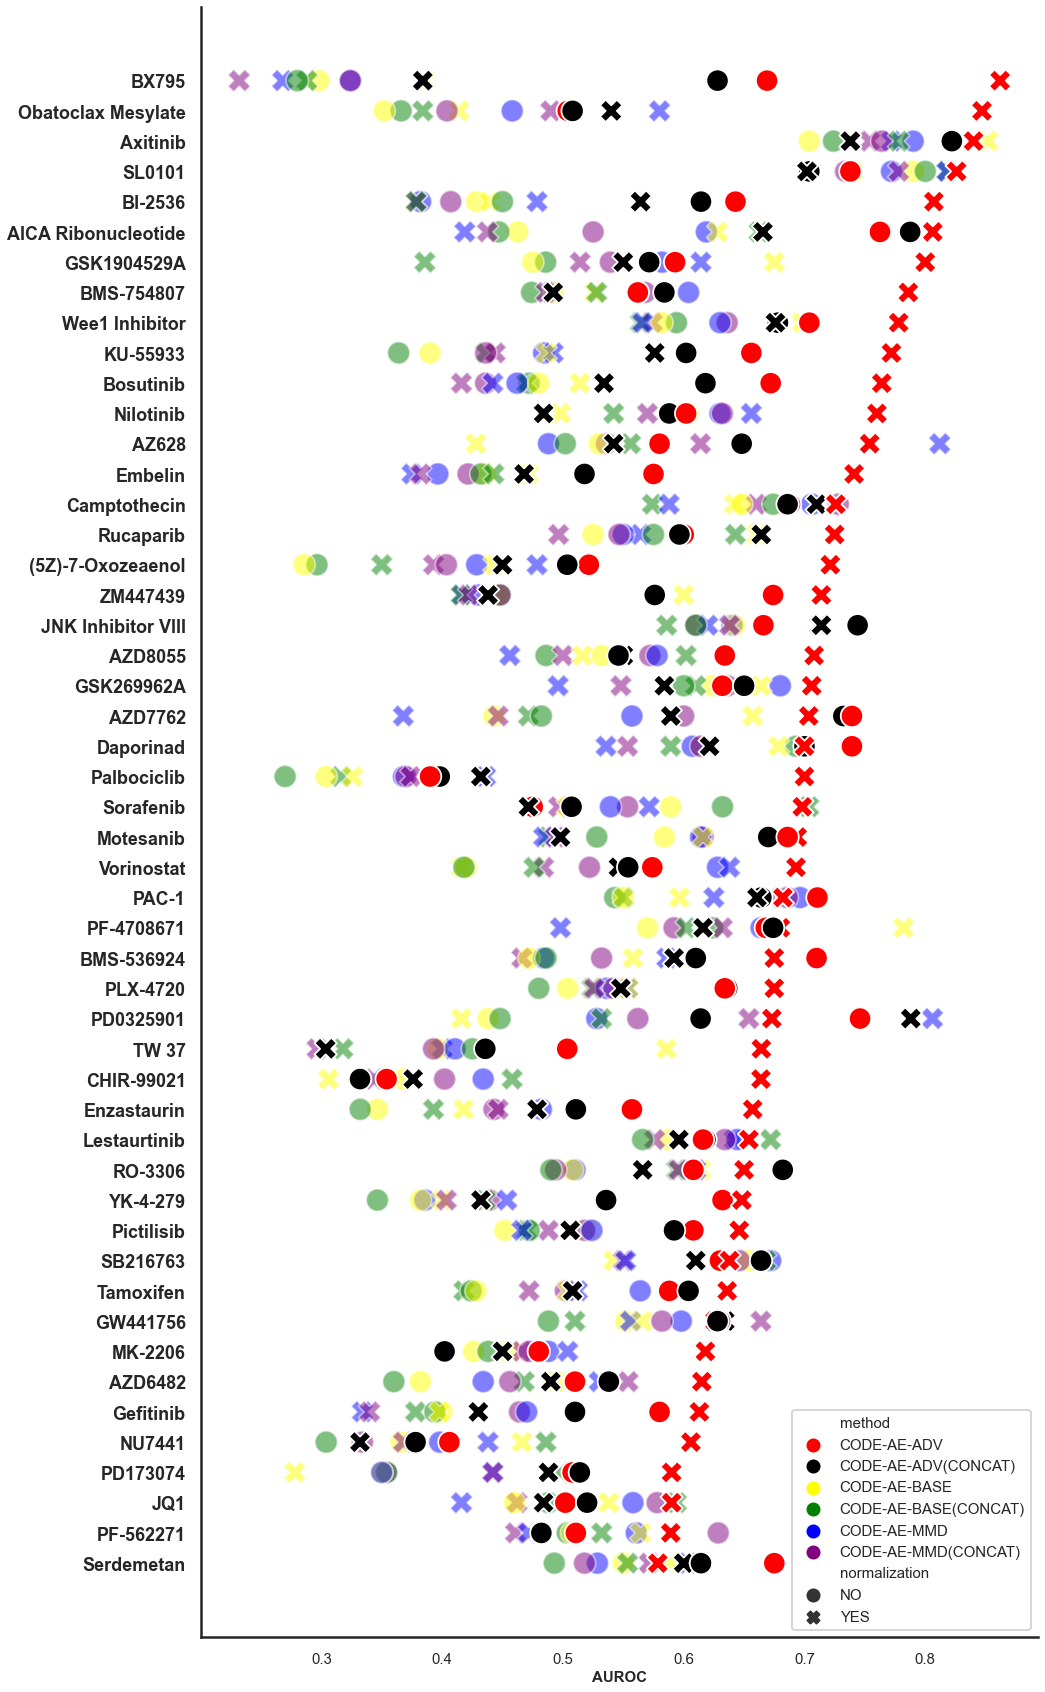

In [9]:
plt.figure(figsize=(15, 30))
sns.set(style='white', context='poster')
ax = sns.scatterplot(x='mean_val', y='drug', hue='method', style='normalization',
                     alpha=0.5,
                     s=500,
                     palette=palette,
                     data=ablation_pdtc_plot_df[ablation_pdtc_plot_df.method.isin(['CODE-AE-MMD','CODE-AE-BASE','CODE-AE-BASE(CONCAT)','CODE-AE-MMD(CONCAT)'])],
                    legend=False)
sns.scatterplot(x='mean_val', y='drug', hue='method', style='normalization',
                alpha=1.0,
                s=500,
                palette=palette,
                data=ablation_pdtc_plot_df[ablation_pdtc_plot_df.method.str.contains('CODE-AE-ADV')]
               )

sns.despine()
plt.ylabel('')
plt.xlabel('AUROC', fontsize=15, weight='bold')
plt.yticks(fontsize=18, weight='bold')
plt.xticks(fontsize=15)
plt.legend(loc='lower right', fontsize=15)
#plt.savefig('../paper/ablation_pdtc_auc.png', format='png', dpi=350,bbox_inches='tight')

## PDTC study result

In [10]:
def build_plot_df(mean_val_df, std_val_df, drug_list, pdtc_flag=False, by='adsn_norm'):
    method_dict = {'tcrp': 'tcrp',
                   'cell_enet':'celligner',
               'dsn':"dsn-mmd", 
               'dsna': 'dsn-dann', 
               'adsn_norm': 'code-ae-adv'
              }

    if pdtc_flag:
        drug_mapping_df = pd.read_csv(data_config.gdsc_pdtc_drug_name_mapping_file, index_col=0)
    else:
        drug_mapping_df = pd.read_csv(data_config.gdsc_tcga_mapping_file, index_col=0)
        
    drug_dict = drug_mapping_df['gdsc_name'].to_dict()
    
    mean_val_df = mean_val_df[drug_list]
    drug_order = mean_val_df.transpose().sort_values(by, ascending=False).index.to_list()
    drug_order = [drug_dict[drug] for drug in drug_order]
    
    mean_val_df = mean_val_df.rename(index=method_dict)
    mean_val_df = mean_val_df.rename(index={k: k.upper() for k in mean_val_df.index})
    mean_val_df = mean_val_df.rename(columns=drug_dict)
    mean_val_df = mean_val_df.stack().rename('mean_val')
    
    std_val_df = std_val_df[drug_list].rename(index=method_dict)
    std_val_df = std_val_df.rename(index={k: k.upper() for k in std_val_df.index})
    std_val_df = std_val_df.rename(columns=drug_dict)
    std_val_df = std_val_df.stack().rename('s.d.')
    std_val_df = pd.cut(std_val_df,
       [0,0.01,0.10,1.0], 
       labels=["<0.01", "0.01-0.10",'>0.10'],
       include_lowest=True,
      )
    std_val_df = std_val_df.cat.set_categories(reversed(std_val_df.cat.categories))
    
    plot_df = mean_val_df.to_frame().join(std_val_df).reset_index().rename(columns={'level_0':'method', 'level_1':'drug'})
    
    plot_df.drug = plot_df.drug.astype('category')
    plot_df.drug.cat.set_categories(drug_order, inplace=True)
    plot_df.sort_values(by='drug', inplace=True)
    
    method_order = ['RF','ENET', 'MLP', 'AE','DAE','VAE','CORAL','DSN-MMD','DSN-DANN', 'TCRP','VAEN','COXEN', 'COXRF','CELLIGNER','ADAE','CODE-AE-ADV']
    plot_df.method = plot_df.method.astype('category')
    plot_df.method.cat.set_categories(method_order, inplace=True)
    plot_df.sort_values(by='method', inplace=True)
    
    plot_df['pre_training'] = 'YES'
    plot_df.loc[plot_df.method.isin(['RF', 'ENET','MLP','TCRP']), 'pre_training']='NO'

    
    return plot_df

    

In [11]:
pdtc_auc_ft_report = pd.read_csv('../intermediate_results/plot_data/pdtc_auc_ft_mean.csv', index_col=0)
pdtc_auc_ft_report_std = pd.read_csv('../intermediate_results/plot_data/pdtc_auc_ft_std.csv',index_col=0)
pdtc_plot_df = build_plot_df(mean_val_df=pdtc_auc_ft_report,
                             std_val_df=pdtc_auc_ft_report_std,
                             drug_list = pdtc_drug_list,
                             pdtc_flag=True,
                             by='adsn_norm'
)

In [12]:
pdtc_auc_ft_report.apply(reverse_rankdata, axis=0).mean(axis=1)

method
cell_enet    11.30
enet         12.90
rf           13.68
mlp          13.52
ae            9.32
dae           9.48
vae           4.26
vaen          6.28
coral         8.56
adae          4.10
tcrp         11.86
dsna          7.58
coxen         7.52
coxerf        7.48
dsn           5.74
adsn_norm     2.12
dtype: float64

In [13]:
pdtc_auc_ft_report.apply(reverse_rankdata, axis=0).std(axis=1)

method
cell_enet    4.404311
enet         2.957177
rf           1.942437
mlp          2.159365
ae           3.119655
dae          2.689663
vae          2.537957
vaen         2.649913
coral        2.900809
adae         1.971739
tcrp         3.030525
dsna         2.634853
coxen        5.131893
coxerf       4.879110
dsn          3.237598
adsn_norm    1.379737
dtype: float64

In [14]:
palette ={
    'ENET':'mediumpurple', 
    'RF':'rebeccapurple',
    'MLP':'purple', 
    'AE':'palegreen',
    'DAE':'limegreen',
    'VAE':'seagreen',
    'VAEN': 'darkgreen',
    'CORAL':'orange',
    'ADAE':'blue', 
    'COXEN':'lightgray',
    'COXRF':'darkgray',
    'CELLIGNER':'darkslategray',
    'DSN-MMD':'gold',
    'DSN-DANN':'yellow', 
    'TCRP':'black',
    'CODE-AE-ADV':'red'}

marker_dict = {
    'ENET':'s', 
    'RF':'s',
    'MLP':'s', 
    'AE':'P',
    'DAE':'P',
    'VAE':'P',
    'VAEN': 'P',
    'CORAL':'H',
    'ADAE':'H', 
    'COXEN':'X',
    'COXRF':'X',
    'CELLIGNER':'X',
    'DSN-MMD':'D',
    'DSN-DANN':'D', 
    'TCRP':'s',
    'CODE-AE-ADV':'o'
}

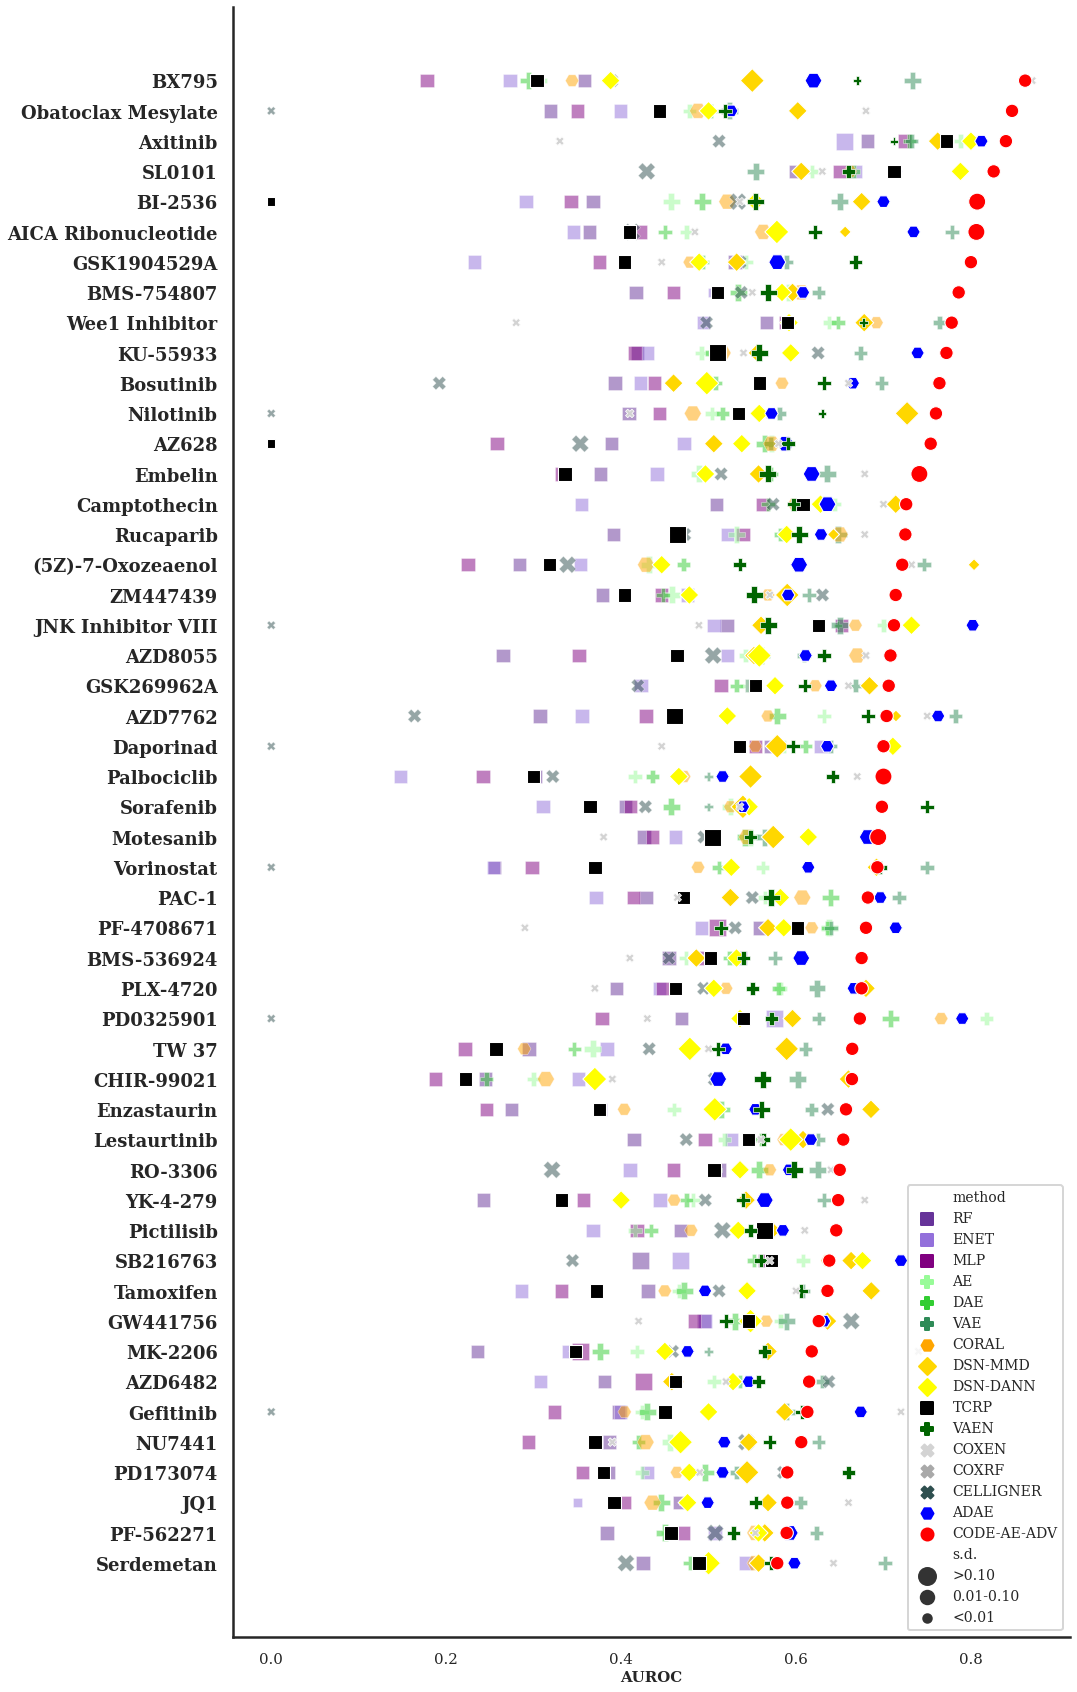

In [15]:
plt.figure(figsize=(15, 30))
sns.set_style('white', {'font.family':'serif', 'font.serif':'Times New Roman'})
ax = sns.scatterplot(x='mean_val', y='drug', hue='method', size='s.d.',style='method', markers=marker_dict,
                     alpha=0.5,
                     s=500,
                     palette=palette,
                     data=pdtc_plot_df[~pdtc_plot_df.method.isin(['CODE-AE-ADV', 'TCRP','VAEN','DSN-MMD','DSN-DANN','ADAE'])],
                    legend=True)
sns.scatterplot(x='mean_val', y='drug', hue='method', size='s.d.',style='method', markers=marker_dict,
                alpha=1.0,
                s=500,
                palette=palette,
                data=pdtc_plot_df[pdtc_plot_df.method.isin(['DSN-MMD','DSN-DANN','ADAE'])],
                legend=False
               )

sns.scatterplot(x='mean_val', y='drug', hue='method', size='s.d.', style='method', markers=marker_dict,
                alpha=1.0,
                s=500,
                palette=palette,
                data=pdtc_plot_df[pdtc_plot_df.method.isin(['TCRP'])],
                legend=False
               )
sns.scatterplot(x='mean_val', y='drug', hue='method', size='s.d.', style='method', markers=marker_dict,
                alpha=1.0,
                s=500,
                palette=palette,
                data=pdtc_plot_df[pdtc_plot_df.method.isin(['VAEN', 'COXEN', 'COXRF'])],
                legend=False
               )

sns.scatterplot(x='mean_val', y='drug', hue='method', size='s.d.',style='method', markers=marker_dict,
                alpha=1.0,
                s=500,
                palette=palette,
                data=pdtc_plot_df[pdtc_plot_df.method.isin(['CODE-AE-ADV'])],
                legend=False
               )


sns.despine()
plt.ylabel('')
plt.xlabel('AUROC', fontsize=15, weight='bold')
plt.yticks(fontsize=18, weight='bold')
plt.xticks(fontsize=15)
plt.legend(loc='lower right', fontsize=14)
#plt.savefig('../paper/pdtc_auc.png', format='png', dpi=350,bbox_inches='tight')

### AUPRC

In [16]:
pdtc_auprc_ft_report = pd.read_csv('../intermediate_results/plot_data/pdtc_auprc_ft_mean.csv', index_col=0)
pdtc_auprc_ft_report_std = pd.read_csv('../intermediate_results/plot_data/pdtc_auprc_ft_std.csv',index_col=0)
pdtc_plot_df = build_plot_df(mean_val_df=pdtc_auprc_ft_report,
                             std_val_df=pdtc_auprc_ft_report_std,
                             drug_list = pdtc_drug_list,
                             pdtc_flag=True,
                             by='adsn_norm'
)

In [17]:
pdtc_auprc_ft_report.apply(reverse_rankdata, axis=0).mean(axis=1)

method
cell_enet    10.88
enet         10.28
rf           13.94
mlp          13.80
ae            9.86
dae           9.64
vae           2.78
vaen          2.62
coral         9.44
adae          4.18
tcrp         12.04
dsna          8.62
coxen         8.20
coxrf         8.06
dsn           8.76
adsn_norm     2.50
dtype: float64

In [18]:
pdtc_auprc_ft_report.apply(reverse_rankdata, axis=0).std(axis=1)

method
cell_enet    6.052964
enet         3.719996
rf           2.054463
mlp          1.538619
ae           2.507214
dae          2.396937
vae          1.607254
vaen         1.496799
coral        2.666190
adae         1.722480
tcrp         2.687537
dsna         2.554628
coxen        4.261838
coxrf        3.760211
dsn          3.054338
adsn_norm    1.631951
dtype: float64

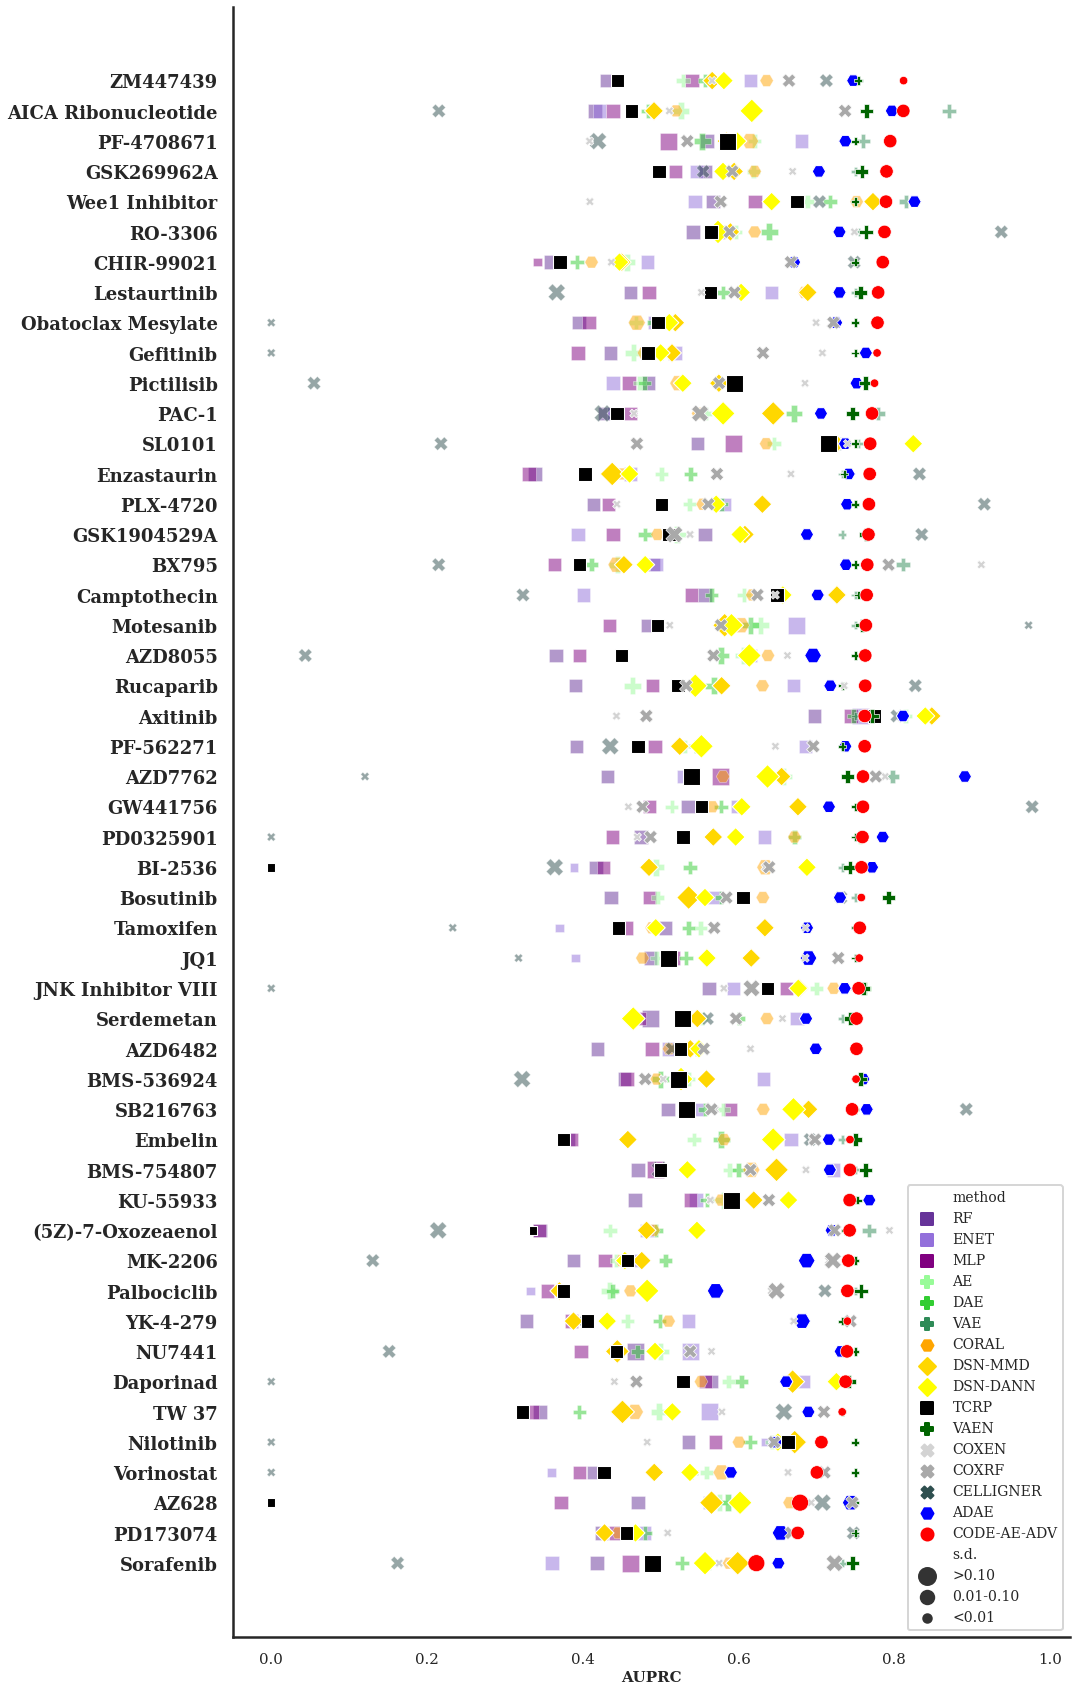

In [19]:
plt.figure(figsize=(15, 30))
sns.set_style('white', {'font.family':'serif', 'font.serif':'Times New Roman'})
ax = sns.scatterplot(x='mean_val', y='drug', hue='method', size='s.d.',style='method', markers=marker_dict,
                     alpha=0.5,
                     s=500,
                     palette=palette,
                     data=pdtc_plot_df[~pdtc_plot_df.method.isin(['CODE-AE-ADV', 'TCRP','VAEN','DSN-MMD','DSN-DANN','ADAE'])],
                    legend=True)
sns.scatterplot(x='mean_val', y='drug', hue='method', size='s.d.',style='method', markers=marker_dict,
                alpha=1.0,
                s=500,
                palette=palette,
                data=pdtc_plot_df[pdtc_plot_df.method.isin(['DSN-MMD','DSN-DANN','ADAE'])],
                legend=False
               )

sns.scatterplot(x='mean_val', y='drug', hue='method', size='s.d.', style='method', markers=marker_dict,
                alpha=1.0,
                s=500,
                palette=palette,
                data=pdtc_plot_df[pdtc_plot_df.method.isin(['TCRP'])],
                legend=False
               )
sns.scatterplot(x='mean_val', y='drug', hue='method', size='s.d.', style='method', markers=marker_dict,
                alpha=1.0,
                s=500,
                palette=palette,
                data=pdtc_plot_df[pdtc_plot_df.method.isin(['VAEN', 'COXEN', 'COXRF'])],
                legend=False
               )

sns.scatterplot(x='mean_val', y='drug', hue='method', size='s.d.',style='method', markers=marker_dict,
                alpha=1.0,
                s=500,
                palette=palette,
                data=pdtc_plot_df[pdtc_plot_df.method.isin(['CODE-AE-ADV'])],
                legend=False
               )


sns.despine()
plt.ylabel('')
plt.xlabel('AUPRC', fontsize=15, weight='bold')
plt.yticks(fontsize=18, weight='bold')
plt.xticks(fontsize=15)
plt.legend(loc='lower right', fontsize=14)
#plt.savefig('../paper/pdtc_auprc.png', format='png', dpi=350,bbox_inches='tight')

## Chemotherapy Drug Response Prediction

In [20]:
def get_largest_kv(d, std_dict):
    k = max(d.items(), key=itemgetter(1))[0]
    return k, d[k], std_dict[k]

def parse_param_str(param_str):
    pattern = re.compile('(pretrain_num_epochs)?_?(\d+)?_?(train_num_epochs)_(\d+)_(dop)_(\d\.\d)')
    matches = pattern.findall(param_str)
    return {matches[0][i]: float(matches[0][i+1]) for i in range(0,len(matches[0]), 2) if matches[0][i] != ''}

def parse_ft_evaluation_result(file_name, method, category, measurement='AUC',metric_name='auroc',pdtc_flag=False,folder='../intermediate_results/plot_data/tcga/model_save'):
    if pdtc_flag:
        folder = f'{folder}/{method}/{measurement}/pdtc/{category}'
    else:
        folder = f'{folder}/{method}/{measurement}/{category}'        
    with open(os.path.join(folder, file_name), 'r') as f:
        result_dict = json.load(f)
    if 'enet' in result_dict:
        result_dict = result_dict['enet'][0]
    return result_dict[metric_name]

In [21]:
import re
from collections import Counter

def parse_hyper_ft_evaluation_result(method, category, measurement='AUC',metric_name='auroc', pdtc_flag = False, folder='../intermediate_results/plot_data/tcga/model_save'):
    if pdtc_flag:
        folder = f'{folder}/{method}/{measurement}/pdtc/{category}'
    else:
        folder = f'{folder}/{method}/{measurement}/{category}'        
    evaluation_metrics = {}
    evaluation_metrics_std = {}
    evaluation_metrics_count = {}
    count = 0
    for file in os.listdir(folder):
        if re.match('(pretrain|train)+.*(dop+).*(ft)+.*\.json', file) or file == 'ft_evaluation_results.json':
            count += 1
            with open(os.path.join(folder, file), 'r') as f:
                result_dict = json.load(f)
            
            if 'enet' in result_dict:
                result_dict = result_dict['enet'][0]
            
            evaluation_metrics[file] = np.mean(result_dict[metric_name])
            evaluation_metrics_std[file] = np.std(result_dict[metric_name])
            evaluation_metrics_count[file] = len(Counter(result_dict[metric_name]))/len(result_dict[metric_name])
    to_exclude = []
    for k, v in evaluation_metrics_count.items():
        if v < 0.2: 
            to_exclude.append(k)
            
    if len(to_exclude)>0:
        for k in to_exclude:
            evaluation_metrics.pop(k)
            evaluation_metrics_std.pop(k)
                    
    return evaluation_metrics, evaluation_metrics_std, count
            

In [22]:
def generate_hyper_ft_report(metric_name='auroc', measurement='AUC', pdtc_flag=False, folder='../intermediate_results/plot_data/tcga/model_save'):
    methods = ['enet','rf', 'cell_enet', 'mlp','ae','dae', 'vae','vaen','coxen','coxrf','coral', 'adae','tcrp','dsna','dsn','adsn_norm']
    #methods = ['ndsn', 'mdsn','adsn', 'ndsn_norm', 'mdsn_norm','ndsn_concat', 'adsn_norm','mdsn_concat','adsn_concat','ndsn_norm_concat', 'mdsn_norm_concat','adsn_norm_concat']
    if pdtc_flag:
        categories = pd.read_csv(data_config.gdsc_pdtc_drug_name_mapping_file, index_col=0).index.tolist()
    else:    
        categories = ['tgem', 'tfu','tem', 'gem', 'cis', 'sor', 'fu']

    #categories = ['female', 'male']
    
    report = pd.DataFrame(np.zeros((len(methods), len(categories))), index=methods, columns=categories)
    report_std = pd.DataFrame(np.zeros((len(methods), len(categories))), index=methods, columns=categories)
    result_dict = defaultdict(dict)

    for cat in categories:
        for method in methods:
            #print(f'{method}: {cat}')
            folder = f'{folder}/{method}'
            try:
                param_str, report.loc[method, cat], report_std.loc[method, cat] = get_largest_kv(d = parse_hyper_ft_evaluation_result(method=method, category=cat, metric_name=metric_name, measurement=measurement, pdtc_flag=pdtc_flag)[0],
                                                                                                std_dict = parse_hyper_ft_evaluation_result(method=method, category=cat, metric_name=metric_name, measurement=measurement, pdtc_flag=pdtc_flag)[1])
                if method in ['enet', 'rf', 'cell_enet']:
                    result_dict[cat][method] = parse_ft_evaluation_result(file_name = 'ft_evaluation_results.json', method=method, category=cat, metric_name=metric_name, measurement=measurement, pdtc_flag=pdtc_flag)
                else:
                    result_dict[cat][method] = parse_ft_evaluation_result(file_name = param_str, 
                                                                          method=method, category=cat, 
                                                                          metric_name=metric_name, 
                                                                          measurement=measurement, 
                                                                          pdtc_flag=pdtc_flag)

            except Exception as e:
                print(e)

                
    return report, report_std, result_dict


In [23]:
auc_ft_report, auc_ft_report_std, auc_ft_result_dict = generate_hyper_ft_report(metric_name='auroc', measurement='AUC')

In [24]:
#average rank when predict chemotherapy prediction on relapses after treatment
auc_ft_report[['tem','gem','cis','sor','fu']].apply(reverse_rankdata, axis=0).mean(axis=1)

enet         11.2
rf           13.8
cell_enet    11.6
mlp          12.2
ae            6.4
dae           8.4
vae           8.2
vaen          4.6
coxen        10.2
coxrf        12.2
coral         7.0
adae          5.2
tcrp         11.4
dsna          6.0
dsn           6.0
adsn_norm     1.6
dtype: float64

In [25]:
#average rank when predict chemotherapy prediction on clinical diagnosis
auc_ft_report[['tgem','tfu']].apply(reverse_rankdata, axis=0).mean(axis=1)

enet         11.0
rf           14.0
cell_enet    13.5
mlp           6.0
ae            6.0
dae           3.0
vae          10.5
vaen         12.0
coxen        13.5
coxrf        16.0
coral         7.5
adae          4.0
tcrp          9.0
dsna          5.0
dsn           4.0
adsn_norm     1.0
dtype: float64

In [26]:
#average rank when predict chemotherapy prediction overall
auc_ft_report.apply(reverse_rankdata, axis=0).mean(axis=1)


enet         11.142857
rf           13.857143
cell_enet    12.142857
mlp          10.428571
ae            6.285714
dae           6.857143
vae           8.857143
vaen          6.714286
coxen        11.142857
coxrf        13.285714
coral         7.142857
adae          4.857143
tcrp         10.714286
dsna          5.714286
dsn           5.428571
adsn_norm     1.428571
dtype: float64

In [27]:
auc_ft_report.apply(reverse_rankdata, axis=0).std(axis=1)


enet         3.848314
rf           1.345185
cell_enet    4.220133
mlp          3.207135
ae           2.058663
dae          3.338092
vae          1.676163
vaen         4.923220
coxen        6.743604
coxrf        3.147183
coral        3.023716
adae         2.410295
tcrp         3.251373
dsna         1.799471
dsn          3.779645
adsn_norm    0.534522
dtype: float64

In [28]:
drug_mapping = pd.read_csv('../data/tcga_gdsc_drug_mapping.csv', index_col=0)

drug_dict = drug_mapping['gdsc_name'].to_dict()
drug_dict['tgem'] = 'Gemcitabine (diagnosis)'
drug_dict['tfu'] = '5-Fluorouracil (diagnosis)'

result_df = None
for cat in ['tgem', 'tfu', 'fu','tem', 'cis', 'sor', 'gem']:
    temp_df = pd.DataFrame.from_dict(auc_ft_result_dict[cat])
    temp_df = temp_df.rename(columns={'tcrp': 'TCRP', 'cell_enet':'CELLIGNER','dsn':"dsn-mmd", 'dsna': 'dsn-dann', 'adsn_norm': 'code-ae-adv'})
    temp_df = temp_df.rename(columns={k: k.upper() for k in temp_df.columns})

    temp_df = pd.melt(temp_df)
    temp_df['drug'] = drug_dict[cat]
    temp_df['metric'] = 'AUC'
    result_df = pd.concat((result_df, temp_df))
        
result_df = result_df.rename(columns={'variable': 'method', 'value': 'auroc'})
method_order = ['RF','ENET', 'CELLIGNER','MLP', 'AE','DAE','VAE','CORAL','DSN-MMD','DSN-DANN', 'TCRP','VAEN','COXEN','COXRF','ADAE','CODE-AE-ADV']
result_df.method = result_df.method.astype('category')
result_df.method.cat.set_categories(method_order, inplace=True)
result_df.sort_values(by='method', inplace=True)

drug_order = ['5-Fluorouracil (diagnosis)', '5-Fluorouracil', 'Temozolomide', 'Sorafenib','Gemcitabine (diagnosis)','Gemcitabine', 'Cisplatin']
result_df.drug = result_df.drug.astype('category')
result_df.drug.cat.set_categories(drug_order, inplace=True)
result_df.sort_values(by='drug', inplace=True)


<Figure size 1080x720 with 0 Axes>

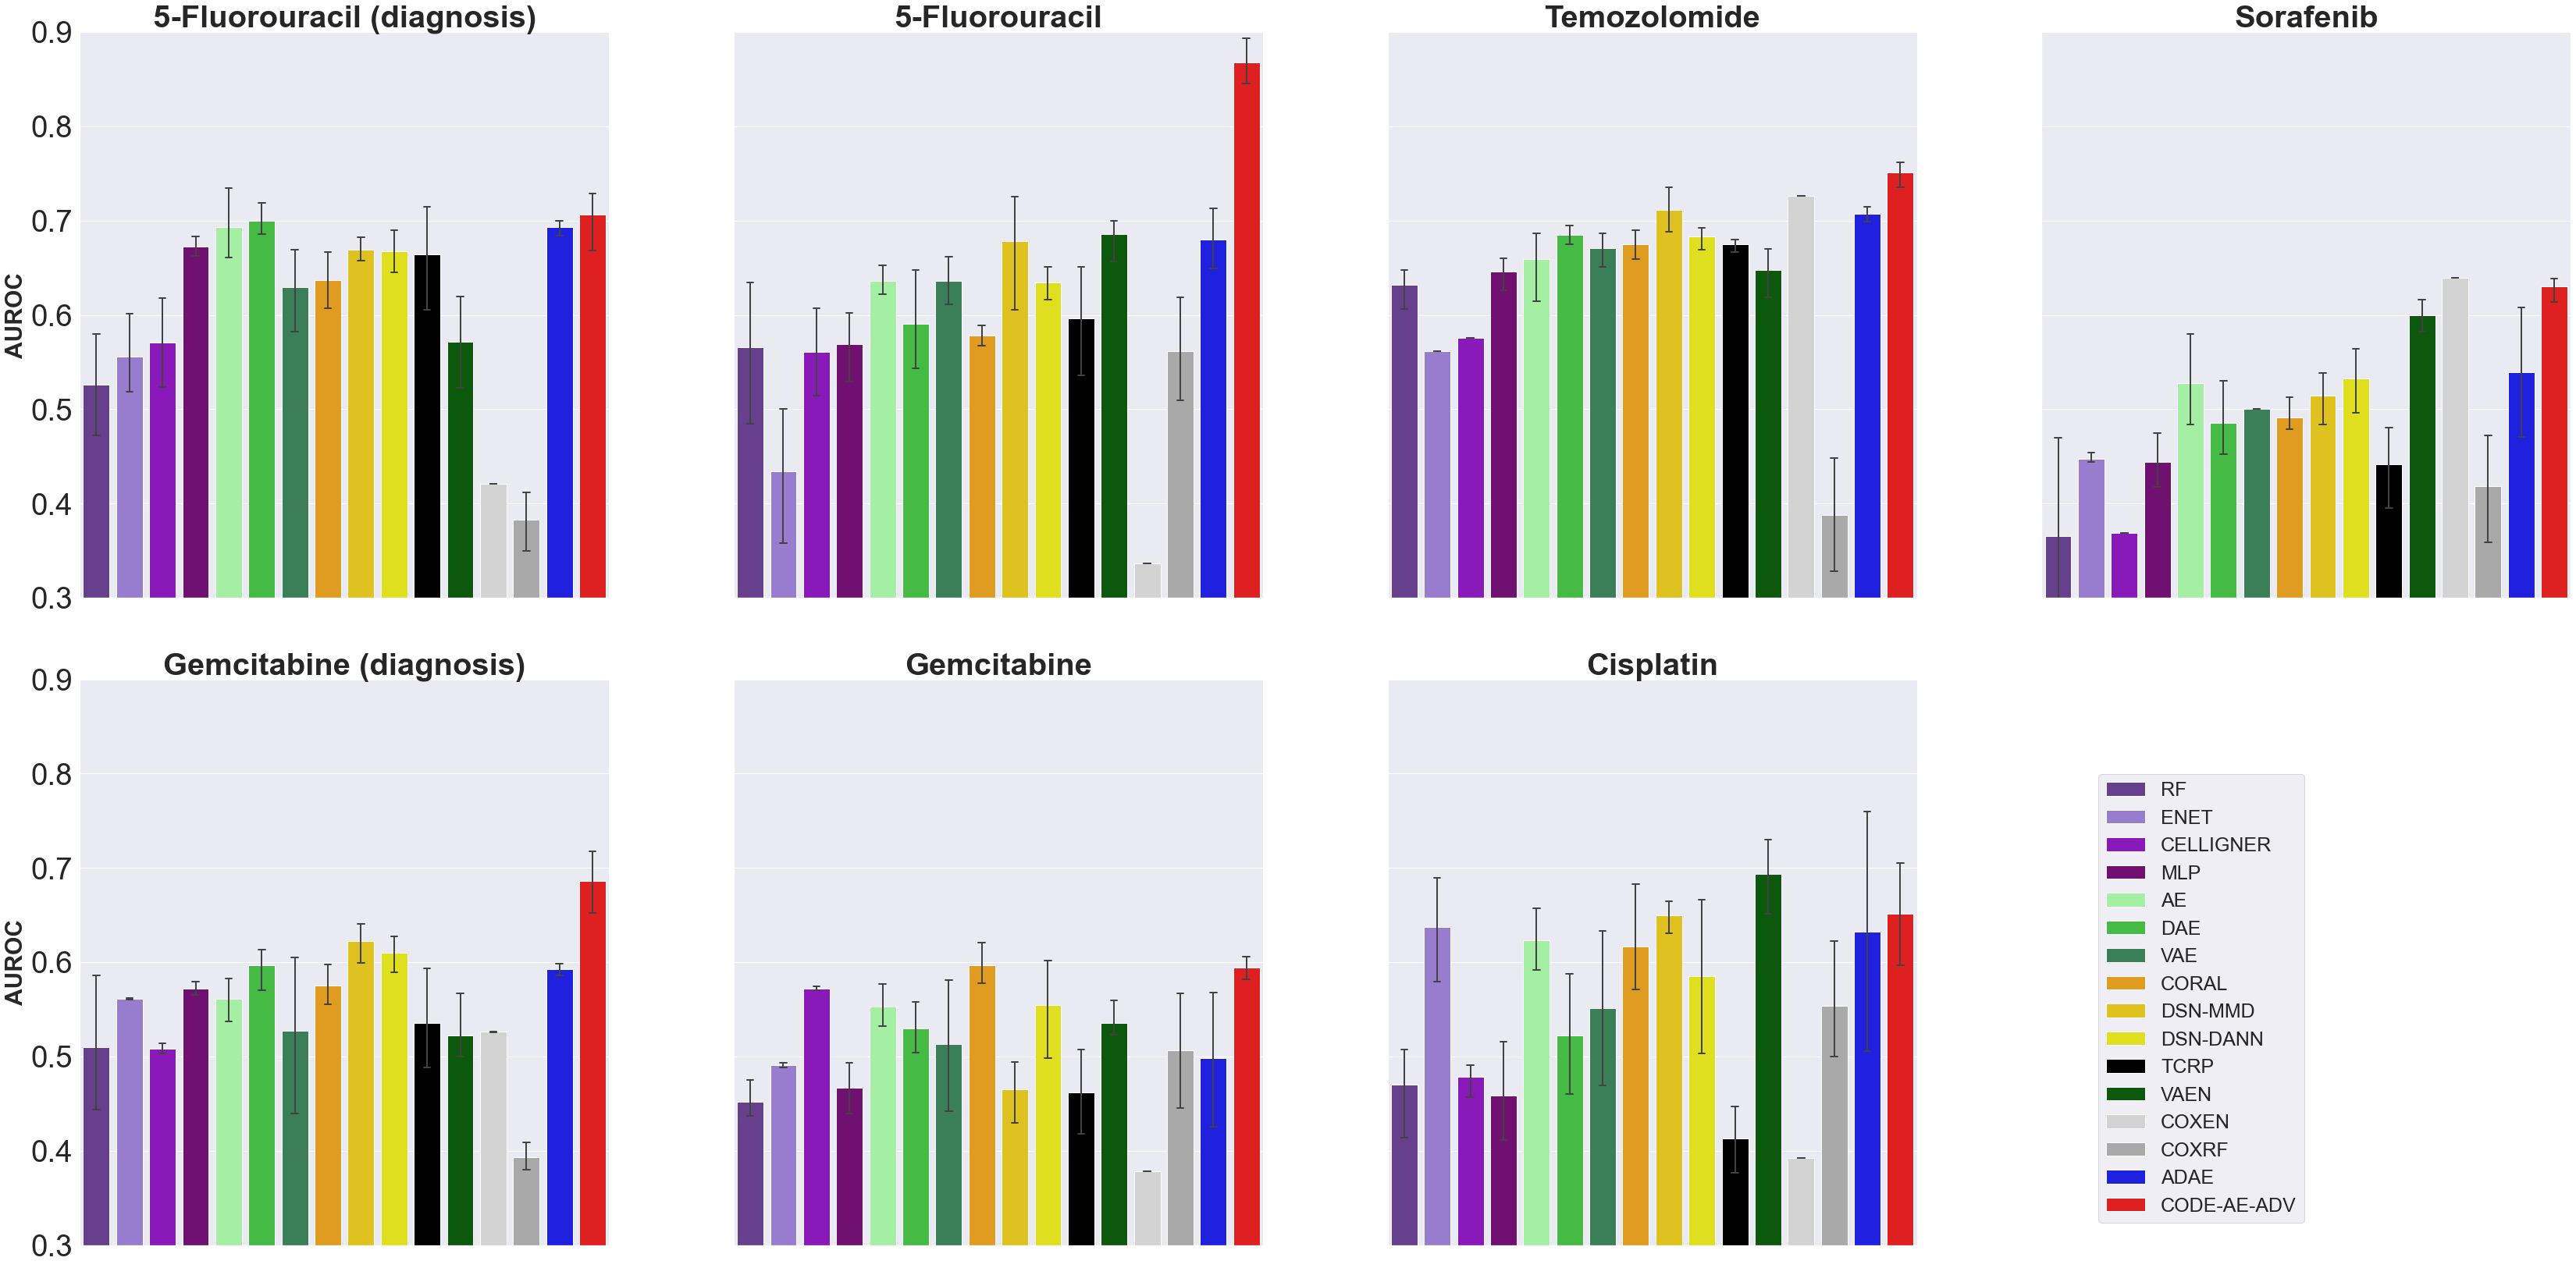

In [29]:
plt.figure(figsize=(15, 10))
sns.set(font_scale = 3.5)
g= sns.FacetGrid(result_df.loc[result_df.metric=='AUC'], col="drug", col_wrap=4, height=12)
g.map_dataframe(sns.barplot, x='method', y='auroc', hue='method', palette=palette, errwidth=2.0, capsize=0.2,dodge=False)
g.despine()
g.set_titles('{col_name}', size=40, weight='bold')
g.set(ylim=(0.3,0.9))
g.set_xlabels('')
g.set_ylabels('AUROC', size=30, weight='bold')
g.set_xticklabels("")
plt.legend(loc='upper right', bbox_to_anchor=(1.75, 0.85), fontsize=25)
#plt.savefig('../paper/tcga_auc_bar.png', format='png', dpi=350,bbox_inches='tight')

In [30]:
## check p vals
print('Gemcitabine (diagnosis)', generate_p_val(a=auc_ft_result_dict['tgem']['adsn_norm'], b=auc_ft_result_dict['tgem']['dsn']))
print('5-Fluorouracil (diagnosis)', generate_p_val(a=auc_ft_result_dict['tfu']['adsn_norm'], b=auc_ft_result_dict['tfu']['dae']))
print('5-Fluorouracil', generate_p_val(a=auc_ft_result_dict['fu']['adsn_norm'], b=auc_ft_result_dict['fu']['dsn']))
print('Temozolomide', generate_p_val(a=auc_ft_result_dict['tem']['adsn_norm'], b=auc_ft_result_dict['tem']['coxen']))
print('Sorafenib', generate_p_val(a=auc_ft_result_dict['sor']['adsn_norm'], b=auc_ft_result_dict['sor']['coxen']))
print('Gemcitabine', generate_p_val(a=auc_ft_result_dict['gem']['adsn_norm'], b=auc_ft_result_dict['gem']['coral']))
print('Cisplatin', generate_p_val(a=auc_ft_result_dict['cis']['adsn_norm'], b=auc_ft_result_dict['cis']['vaen']))

ttest_ind:            t = 2.76614  p = 0.0289969
Gemcitabine (diagnosis) None
ttest_ind:            t = 0.325404  p = 0.755977
5-Fluorouracil (diagnosis) None
ttest_ind:            t = 5.28742  p = 0.00277022
5-Fluorouracil None
ttest_ind:            t = 3.31203  p = 0.0295982
Temozolomide None
ttest_ind:            t = -1.0308  p = 0.360879
Sorafenib None
ttest_ind:            t = -0.164713  p = 0.874624
Gemcitabine None
ttest_ind:            t = -1.09289  p = 0.310245
Cisplatin None


### AUPRC

In [31]:
auprc_ft_report, auprc_ft_report_std, auprc_ft_result_dict = generate_hyper_ft_report(metric_name='auprc', measurement='AUPRC')

In [32]:
#average rank when predict chemotherapy prediction on relapses after treatment
auprc_ft_report[['tem','gem','cis','sor','fu']].apply(reverse_rankdata, axis=0).mean(axis=1)

enet         11.4
rf           13.6
cell_enet     9.8
mlp          12.0
ae            9.8
dae           9.4
vae           2.6
vaen          2.0
coxen        11.8
coxrf        11.6
coral         7.6
adae          3.6
tcrp         12.8
dsna          7.0
dsn           8.2
adsn_norm     2.4
dtype: float64

In [33]:
#average rank when predict chemotherapy prediction on clinical diagnosis
auprc_ft_report[['tgem','tfu']].apply(reverse_rankdata, axis=0).mean(axis=1)

enet         10.0
rf           14.5
cell_enet    10.0
mlp          11.0
ae            8.0
dae           7.5
vae           2.0
vaen          2.0
coxen        11.5
coxrf        16.0
coral        11.0
adae          2.0
tcrp         12.0
dsna          8.0
dsn           6.5
adsn_norm     2.0
dtype: float64

In [34]:
#average rank when predict chemotherapy prediction overall
auprc_ft_report.apply(reverse_rankdata, axis=0).mean(axis=1)


enet         11.000000
rf           13.857143
cell_enet     9.857143
mlp          11.714286
ae            9.285714
dae           8.857143
vae           2.428571
vaen          2.000000
coxen        11.714286
coxrf        12.857143
coral         8.571429
adae          3.142857
tcrp         12.571429
dsna          7.285714
dsn           7.714286
adsn_norm     2.285714
dtype: float64

In [35]:
auprc_ft_report.apply(reverse_rankdata, axis=0).std(axis=1)


enet         3.829708
rf           1.463850
cell_enet    4.336995
mlp          1.976047
ae           2.811541
dae          2.478479
vae          0.975900
vaen         1.414214
coxen        5.089672
coxrf        3.236694
coral        2.572751
adae         1.214986
tcrp         1.902379
dsna         1.976047
dsn          3.860669
adsn_norm    1.253566
dtype: float64

In [36]:
result_df = None
for cat in ['tgem', 'tfu', 'fu','tem', 'cis', 'sor', 'gem']:
    temp_df = pd.DataFrame.from_dict(auprc_ft_result_dict[cat])
    temp_df = temp_df.rename(columns={'tcrp': 'TCRP','dsn':"dsn-mmd", 'dsna': 'dsn-dann', 'adsn_norm': 'code-ae-adv'})
    temp_df = temp_df.rename(columns={k: k.upper() for k in temp_df.columns})

    temp_df = pd.melt(temp_df)
    temp_df['drug'] = drug_dict[cat]
    temp_df['metric'] = 'AUPRC'
    result_df = pd.concat((result_df, temp_df))
        
result_df = result_df.rename(columns={'variable': 'method', 'value': 'auprc'})
method_order = ['RF','ENET', 'MLP', 'AE','DAE','VAE','CORAL','DSN-MMD','DSN-DANN', 'TCRP','VAEN','COXEN','COXRF','ADAE','CODE-AE-ADV']
result_df.method = result_df.method.astype('category')
result_df.method.cat.set_categories(method_order, inplace=True)
result_df.sort_values(by='method', inplace=True)

drug_order = ['5-Fluorouracil (diagnosis)', '5-Fluorouracil', 'Temozolomide', 'Sorafenib','Gemcitabine (diagnosis)','Gemcitabine', 'Cisplatin']
result_df.drug = result_df.drug.astype('category')
result_df.drug.cat.set_categories(drug_order, inplace=True)
result_df.sort_values(by='drug', inplace=True)


<Figure size 1080x720 with 0 Axes>

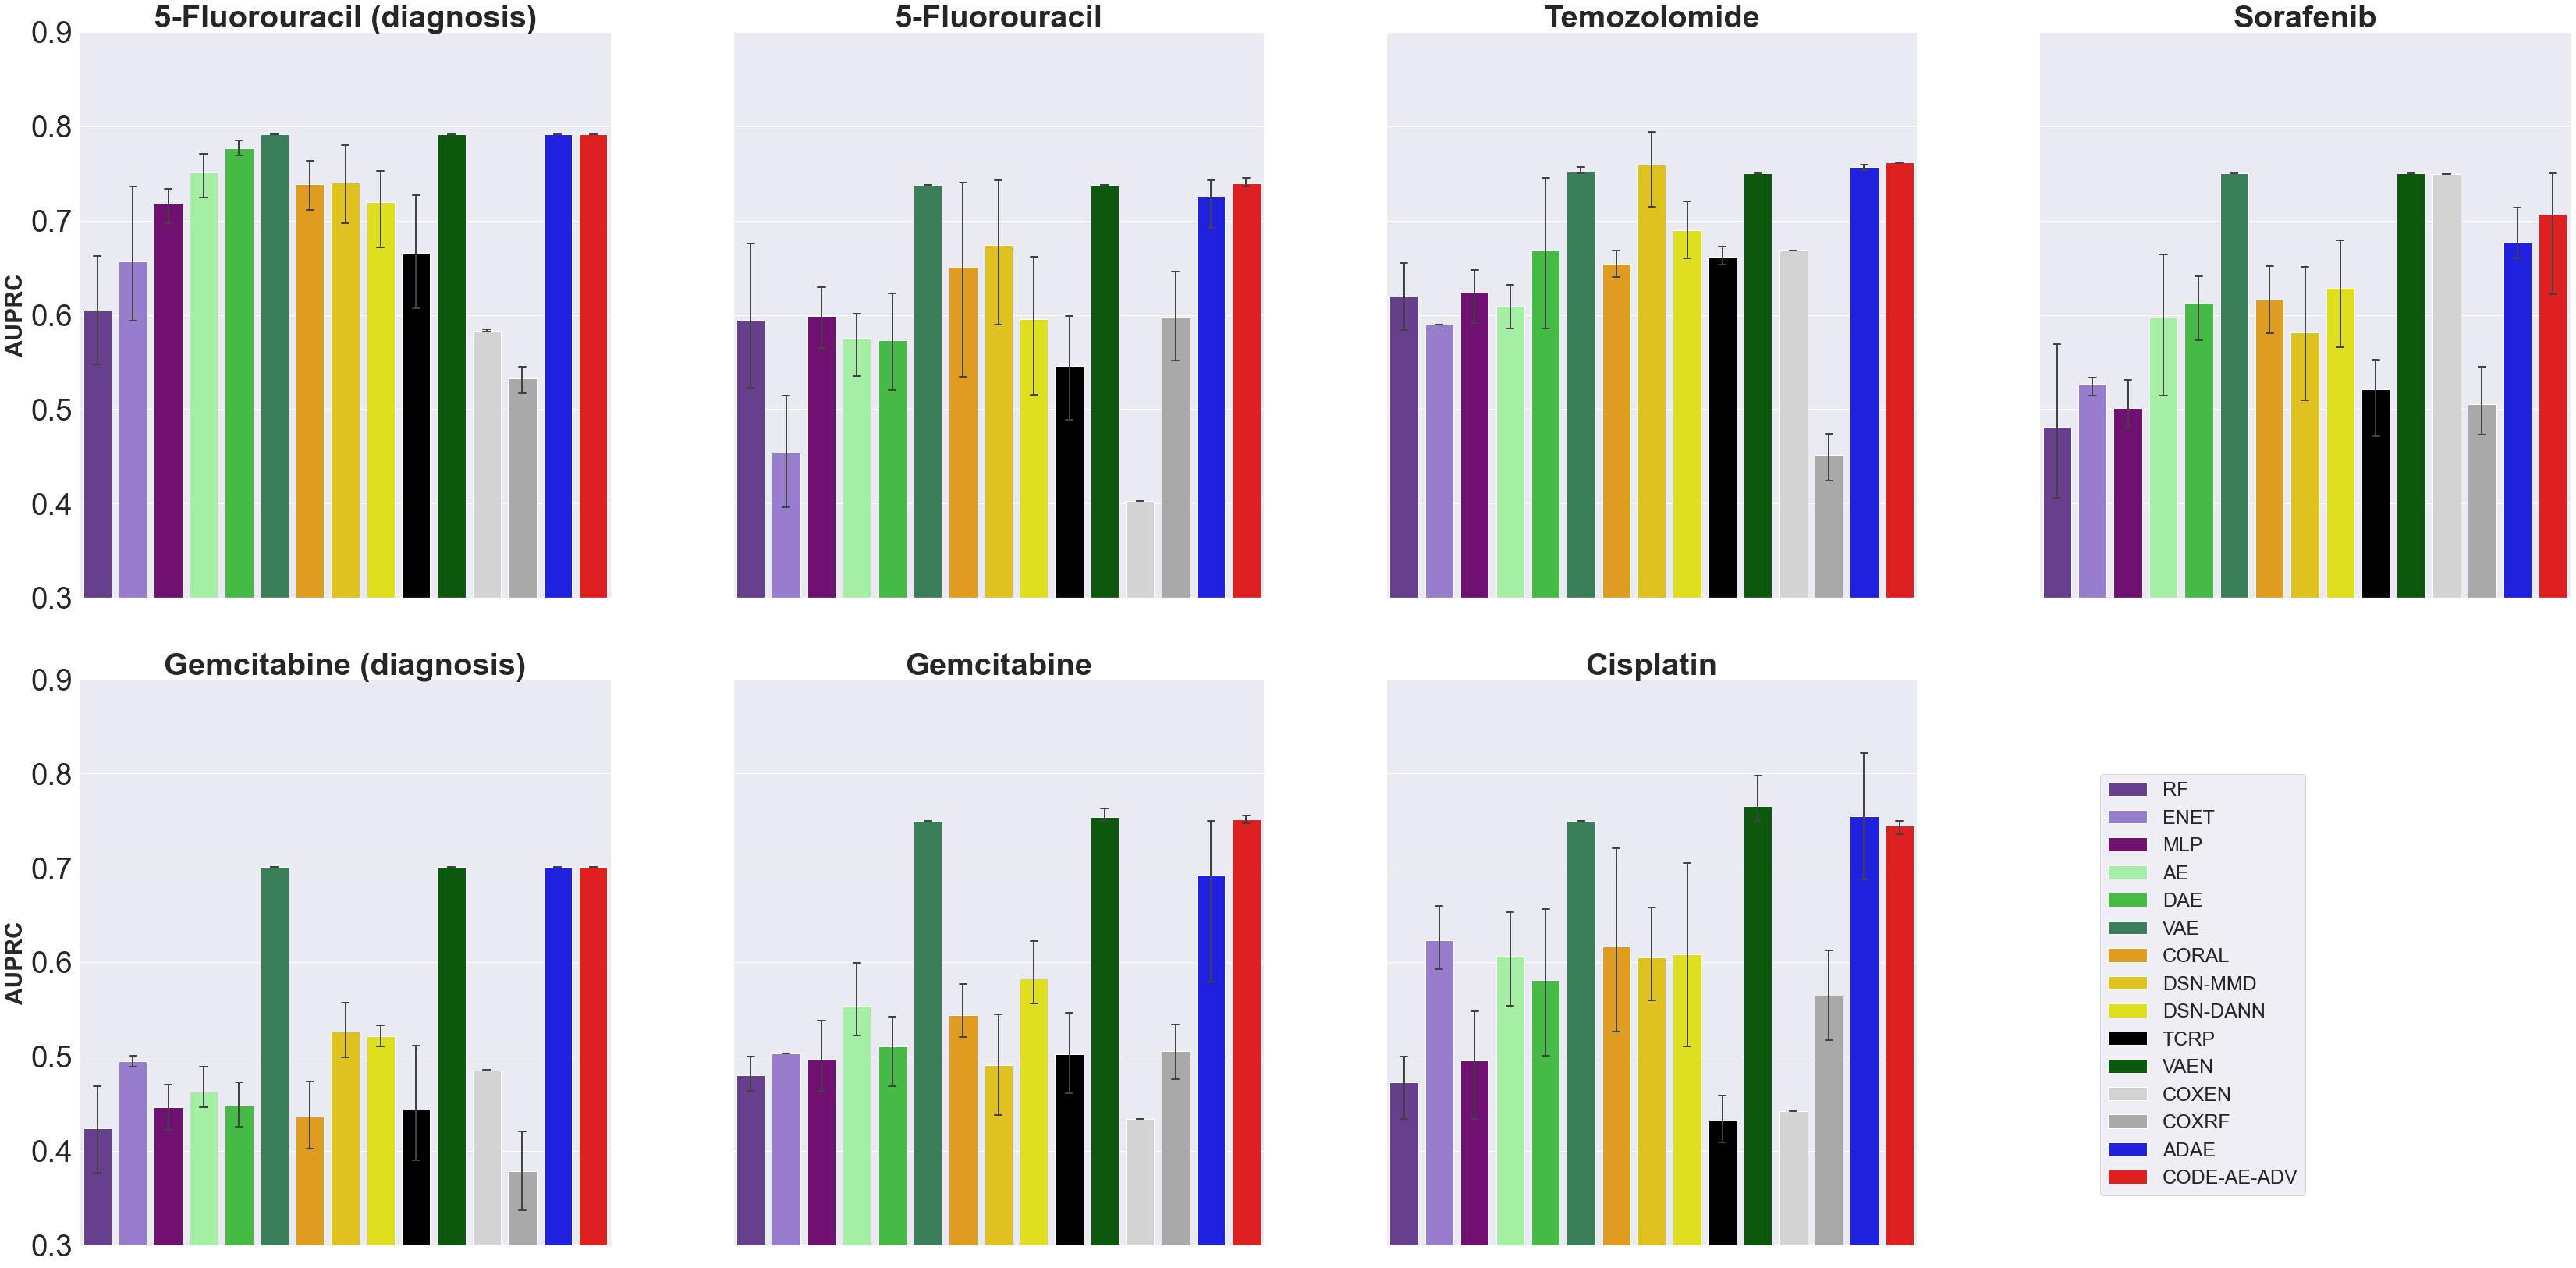

In [37]:
plt.figure(figsize=(15, 10))
sns.set(font_scale = 3.5)
g= sns.FacetGrid(result_df.loc[result_df.metric=='AUPRC'], col="drug", col_wrap=4, height=12)
g.map_dataframe(sns.barplot, x='method', y='auprc', hue='method', palette=palette, errwidth=2.0, capsize=0.2,dodge=False)
g.despine()
g.set_titles('{col_name}', size=40, weight='bold')
g.set(ylim=(0.3,0.9))
g.set_xlabels('')
g.set_ylabels('AUPRC', size=30, weight='bold')
g.set_xticklabels("")
plt.legend(loc='upper right', bbox_to_anchor=(1.75, 0.85), fontsize=25)
#plt.savefig('../paper/tcga_auprc_bar.png', format='png', dpi=350,bbox_inches='tight')

In [38]:
## check p vals
print('Gemcitabine (diagnosis)', generate_p_val(a=auc_ft_result_dict['tgem']['adsn_norm'], b=auc_ft_result_dict['tgem']['adae']))
print('5-Fluorouracil (diagnosis)', generate_p_val(a=auc_ft_result_dict['tfu']['adsn_norm'], b=auc_ft_result_dict['tfu']['adae']))
print('5-Fluorouracil', generate_p_val(a=auc_ft_result_dict['fu']['adsn_norm'], b=auc_ft_result_dict['fu']['vaen']))
print('Temozolomide', generate_p_val(a=auc_ft_result_dict['tem']['adsn_norm'], b=auc_ft_result_dict['tem']['adae']))
print('Sorafenib', generate_p_val(a=auc_ft_result_dict['sor']['adsn_norm'], b=auc_ft_result_dict['sor']['vaen']))
print('Gemcitabine', generate_p_val(a=auc_ft_result_dict['gem']['adsn_norm'], b=auc_ft_result_dict['gem']['vaen']))
print('Cisplatin', generate_p_val(a=auc_ft_result_dict['cis']['adsn_norm'], b=auc_ft_result_dict['cis']['vaen']))

ttest_ind:            t = 4.73614  p = 0.00765258
Gemcitabine (diagnosis) None
ttest_ind:            t = 0.699231  p = 0.518632
5-Fluorouracil (diagnosis) None
ttest_ind:            t = 9.21955  p = 1.62643e-05
5-Fluorouracil None
ttest_ind:            t = 4.94461  p = 0.0020183
Temozolomide None
ttest_ind:            t = 2.42565  p = 0.0419999
Sorafenib None
ttest_ind:            t = 4.27548  p = 0.00446134
Gemcitabine None
ttest_ind:            t = -1.09289  p = 0.310245
Cisplatin None


## TCGA application

In [237]:
with gzip.open('../data/raw_dat/Xena/TCGA_phenotype_denseDataOnlyDownload.tsv.gz') as f:
    xena_sample_info_df = pd.read_csv(f, sep='\t', index_col=0)
    

In [238]:
score_df = pd.read_csv('../intermediate_results/tcga_prediction/tcga_scores.csv', index_col=0)
chemo_drugs = ['Fluorouracil', 'Gemcitabine', 'Cisplatin', 'Temozolomide','Sorafenib.1','Doxorubicin','Sunitinib','Carmustine','Paclitaxel']
score_df.drop(columns=chemo_drugs, inplace=True)
score_df.sort_values('_primary_disease', inplace=True)

In [239]:
score_df_mat = score_df.drop(columns=['_primary_disease'])
drug_info = pd.read_csv('../data/drug_info.csv', index_col=0)
drug_info['Drug'] = drug_info['Name']
temp_drug_info = drug_info.assign(Drug=drug_info['Synonyms'].str.split(',')).explode('Drug')
drug_info = pd.concat([drug_info, temp_drug_info])
drug_info = drug_info.assign(Target=drug_info['Targets'].str.split(',')).explode('Target')
drug_info['Drug'] = drug_info.Drug.str.strip()
drug_info.sort_values('Name', inplace=True)
drug_info.drop_duplicates(subset=['Drug','Target'], inplace=True)
drug_info.drop_duplicates(inplace=True)
drug_info.set_index('Drug', inplace=True)

### Spectral co-clustering on drugs

In [240]:
num_clusters = len(drug_info['Target pathway'].value_counts())

In [241]:
model = SpectralCoclustering(n_clusters=num_clusters, random_state=0)
model.fit(score_df_mat)


SpectralCoclustering(n_clusters=21, random_state=0)

In [242]:
for i in range(num_clusters):
    val = np.mean(model.get_submatrix(i, score_df_mat))
    print(f'Cluster-{i}: ', val)


Cluster-0:  0.9033319510568414
Cluster-1:  0.7392688332710947
Cluster-2:  nan
Cluster-3:  0.6764134558023788
Cluster-4:  0.4493498557848455
Cluster-5:  nan
Cluster-6:  0.6738918304584938
Cluster-7:  0.5049170378077725
Cluster-8:  0.782863023241361
Cluster-9:  0.4678412029792651
Cluster-10:  0.6382741796213482
Cluster-11:  0.6969112297238959
Cluster-12:  nan
Cluster-13:  0.6685371412682533
Cluster-14:  0.5661878260291942
Cluster-15:  nan
Cluster-16:  0.5415550679257422
Cluster-17:  0.7444995310294834
Cluster-18:  0.6129646726340843
Cluster-19:  nan
Cluster-20:  0.5698786023790989


In [243]:
def get_cluster_info(cluster_id, model=model, data=score_df_mat, drug_info=drug_info, sample_info=xena_sample_info_df):
    cluster_rows = data.index[model.get_indices(cluster_id)[0]]
    cluster_cols = data.columns[model.get_indices(cluster_id)[1]]
    cluster_drug = drug_info.loc[cluster_cols, ['Targets', 'Target pathway']].drop_duplicates()
    cluster_sample = sample_info.loc[cluster_rows]._primary_disease.value_counts()
    
    return cluster_drug, cluster_sample
    
    

In [244]:
for i in range(num_clusters):
    val = np.mean(model.get_submatrix(i, score_df_mat))
    if not np.isnan(val):
        print(f'Cluster-{i}: ', val)
        cluster_drug, cluster_sample = get_cluster_info(i)
        #print(cluster_drug)
        cluster_drug.to_csv(f'../intermediate_results/tcga_prediction/bi_cluster/cluster_{i}_drug_info.csv')
        pd.DataFrame(cluster_sample).to_csv(f'../intermediate_results/tcga_prediction/bi_cluster/cluster_{i}_sample_counts.csv')

Cluster-0:  0.9033319510568414
Cluster-1:  0.7392688332710947
Cluster-3:  0.6764134558023788
Cluster-4:  0.4493498557848455
Cluster-6:  0.6738918304584938
Cluster-7:  0.5049170378077725
Cluster-8:  0.782863023241361
Cluster-9:  0.4678412029792651
Cluster-10:  0.6382741796213482
Cluster-11:  0.6969112297238959
Cluster-13:  0.6685371412682533
Cluster-14:  0.5661878260291942
Cluster-16:  0.5415550679257422
Cluster-17:  0.7444995310294834
Cluster-18:  0.6129646726340843
Cluster-20:  0.5698786023790989


In [245]:
tissue_name_dict = {'brain lower grade glioma': 'brain lower \n grade glioma', 
                    'pheochromocytoma & paraganglioma':'pheochromocytoma &\n paraganglioma',
                    'glioblastoma multiforme':'glioblastoma \n multiforme', 
                    'adrenocortical cancer':'adrenocortical \n cancer'}

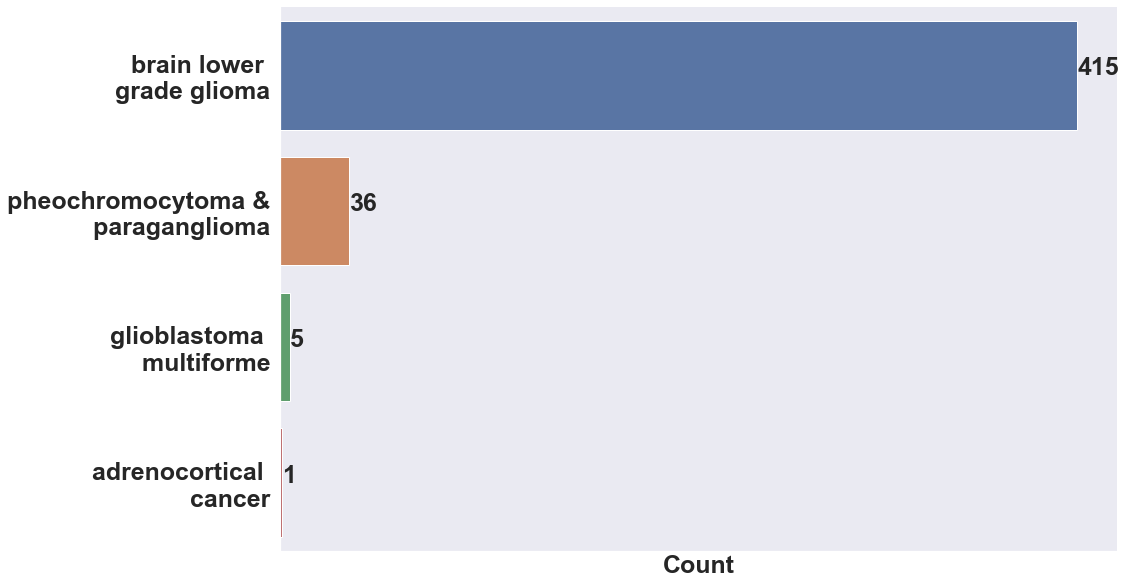

In [246]:
_, cluster_samples = get_cluster_info(0)
cluster_samples.index = cluster_samples.index.map(tissue_name_dict)
plt.figure(figsize=(15,10))
sns.set(font_scale = 1.5)
ax = sns.barplot(y='index', x='_primary_disease', data=cluster_samples.reset_index())
sns.despine()
for rect in ax.patches:
    ax.text (rect.get_width(), rect.get_y() + rect.get_height() / 2,"%d"% rect.get_width(), weight='bold',fontsize=25)
plt.xlabel('Count', fontsize=25, weight='bold')
plt.ylabel("")
plt.yticks(fontsize=25, weight='bold')
plt.xticks([], fontsize=25)
ax.xaxis.tick_top()
#plt.savefig(f'../intermediate_results/tcga_prediction/bi_cluster/cluster0_sample_counts.png', format='png', dpi=350,bbox_inches='tight')


(array([0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95]),
 [Text(0.7000000000000001, 0, '0.70'),
  Text(0.7500000000000001, 0, '0.75'),
  Text(0.8, 0, '0.80'),
  Text(0.8500000000000001, 0, '0.85'),
  Text(0.9000000000000001, 0, '0.90'),
  Text(0.9500000000000001, 0, '0.95')])

<Figure size 1080x720 with 0 Axes>

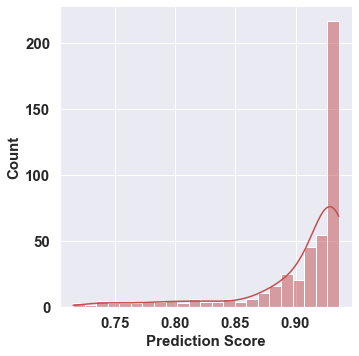

In [247]:
cluster_rows = score_df_mat.index[model.get_indices(0)[0]]
plt.figure(figsize=(15,10))
sns.set(font_scale = 1.0)

sns.displot(score_df_mat.loc[cluster_rows,'PD-173074'], color='r', kde=True)
plt.xlabel("Prediction Score", weight='bold',fontsize=15)
plt.ylabel("Count", weight='bold',fontsize=15)
plt.yticks(fontsize=15, weight='bold')
plt.xticks(fontsize=15, weight='bold')

#plt.savefig(f'../intermediate_results/tcga_prediction/bi_cluster/cluster0_dist.png', format='png', dpi=350,bbox_inches='tight')


In [248]:
cluster_mask_df = pd.DataFrame(np.zeros_like(score_df_mat), index=score_df_mat.index, columns=score_df_mat.columns)
for cluster_id in range(num_clusters):
    cluster_rows = score_df_mat.index[model.get_indices(cluster_id)[0]]
    cluster_cols = score_df_mat.columns[model.get_indices(cluster_id)[1]]
    cluster_mask_df.loc[cluster_rows, cluster_cols] = cluster_id+1
fit_data = score_df_mat.values[np.argsort(model.row_labels_)]
drug_orders = score_df_mat.index[np.argsort(model.row_labels_)]
fit_data = fit_data[:, np.argsort(model.column_labels_)]
sample_orders = score_df_mat.columns[np.argsort(model.column_labels_)]
fit_data = pd.DataFrame(fit_data, index=drug_orders, columns=sample_orders)
fit_data_mask = cluster_mask_df.values[np.argsort(model.row_labels_)]
drug_orders = cluster_mask_df.index[np.argsort(model.row_labels_)]
fit_data_mask = fit_data_mask[:, np.argsort(model.column_labels_)]
sample_orders = cluster_mask_df.columns[np.argsort(model.column_labels_)]
fit_data_mask = pd.DataFrame(fit_data_mask, index=drug_orders, columns=sample_orders)
fit_data_mask = fit_data_mask.astype('int')

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
        22.5, 23.5, 24.5, 25.5, 26.5, 27.5, 28.5, 29.5, 30.5, 31.5, 32.5,
        33.5, 34.5, 35.5, 36.5, 37.5, 38.5, 39.5, 40.5, 41.5, 42.5, 43.5,
        44.5, 45.5, 46.5, 47.5, 48.5, 49.5]),
 [Text(0, 0.5, 'PD-173074'),
  Text(0, 1.5, 'Tamoxifen'),
  Text(0, 2.5, 'Vorinostat'),
  Text(0, 3.5, 'AICAR'),
  Text(0, 4.5, 'Obatoclax Mesylate'),
  Text(0, 5.5, 'TW 37'),
  Text(0, 6.5, 'PD-0325901'),
  Text(0, 7.5, 'PLX4720'),
  Text(0, 8.5, 'JNK Inhibitor VIII'),
  Text(0, 9.5, 'BMS-536924'),
  Text(0, 10.5, 'GDC0941'),
  Text(0, 11.5, 'GW 441756'),
  Text(0, 12.5, 'PF-4708671'),
  Text(0, 13.5, 'AG-014699'),
  Text(0, 14.5, 'PAC-1'),
  Text(0, 15.5, 'BMS-754807'),
  Text(0, 16.5, 'BI-2536'),
  Text(0, 17.5, 'AZD8055'),
  Text(0, 18.5, 'SB 216763'),
  Text(0, 19.5, 'Bosutinib'),
  Text(0, 20.5, 'AMG-706'),
  Text(0, 21.5, 'CHIR-99021'),
  Text

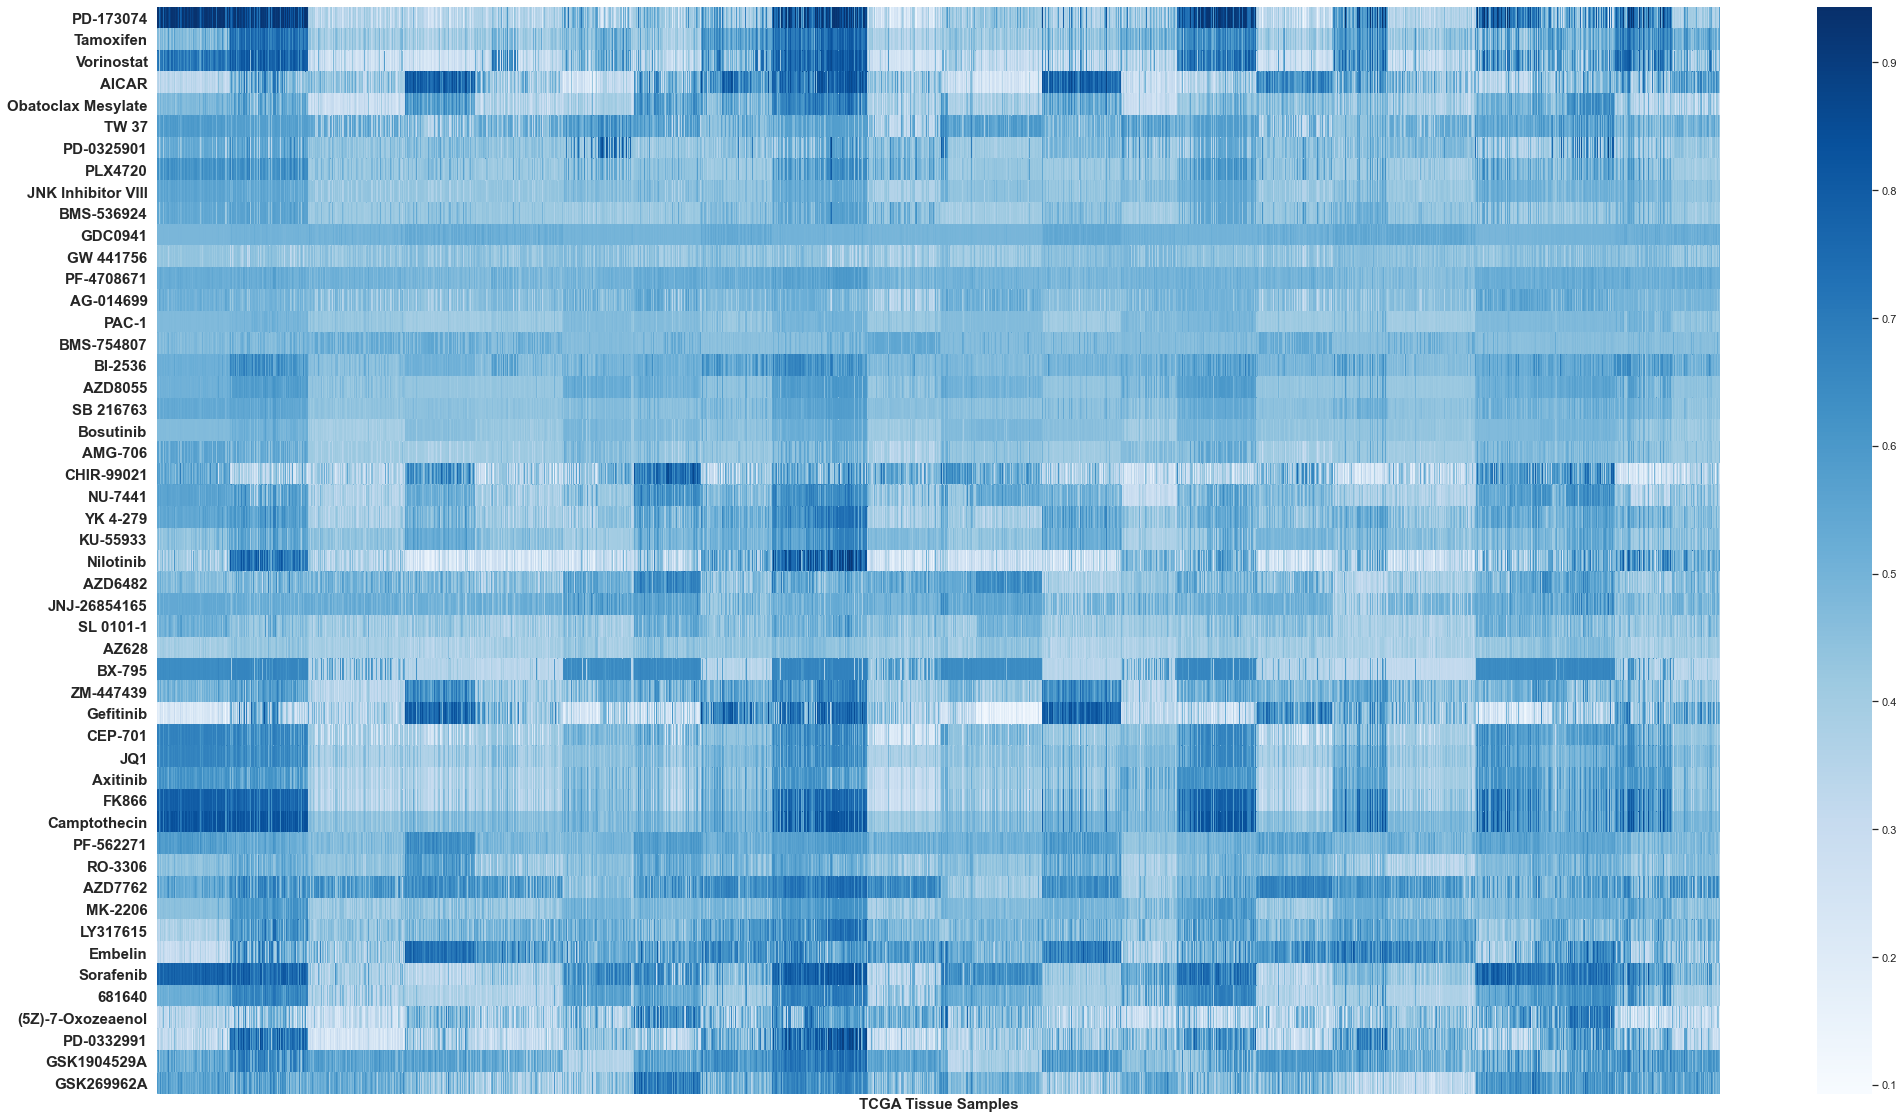

In [249]:
plt.figure(figsize=(35,20))

ax = sns.heatmap(fit_data.transpose(), cmap=sns.color_palette("Blues", as_cmap=True))

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

plt.xlabel("TCGA Tissue Samples", fontsize=15,weight='bold')
plt.yticks(fontsize=15, weight='bold')

#plt.savefig(f'../intermediate_results/tcga_prediction/bi_cluster/bi_cluster_number_of_unique_pathway_21.png', format='png', dpi=350,bbox_inches='tight')


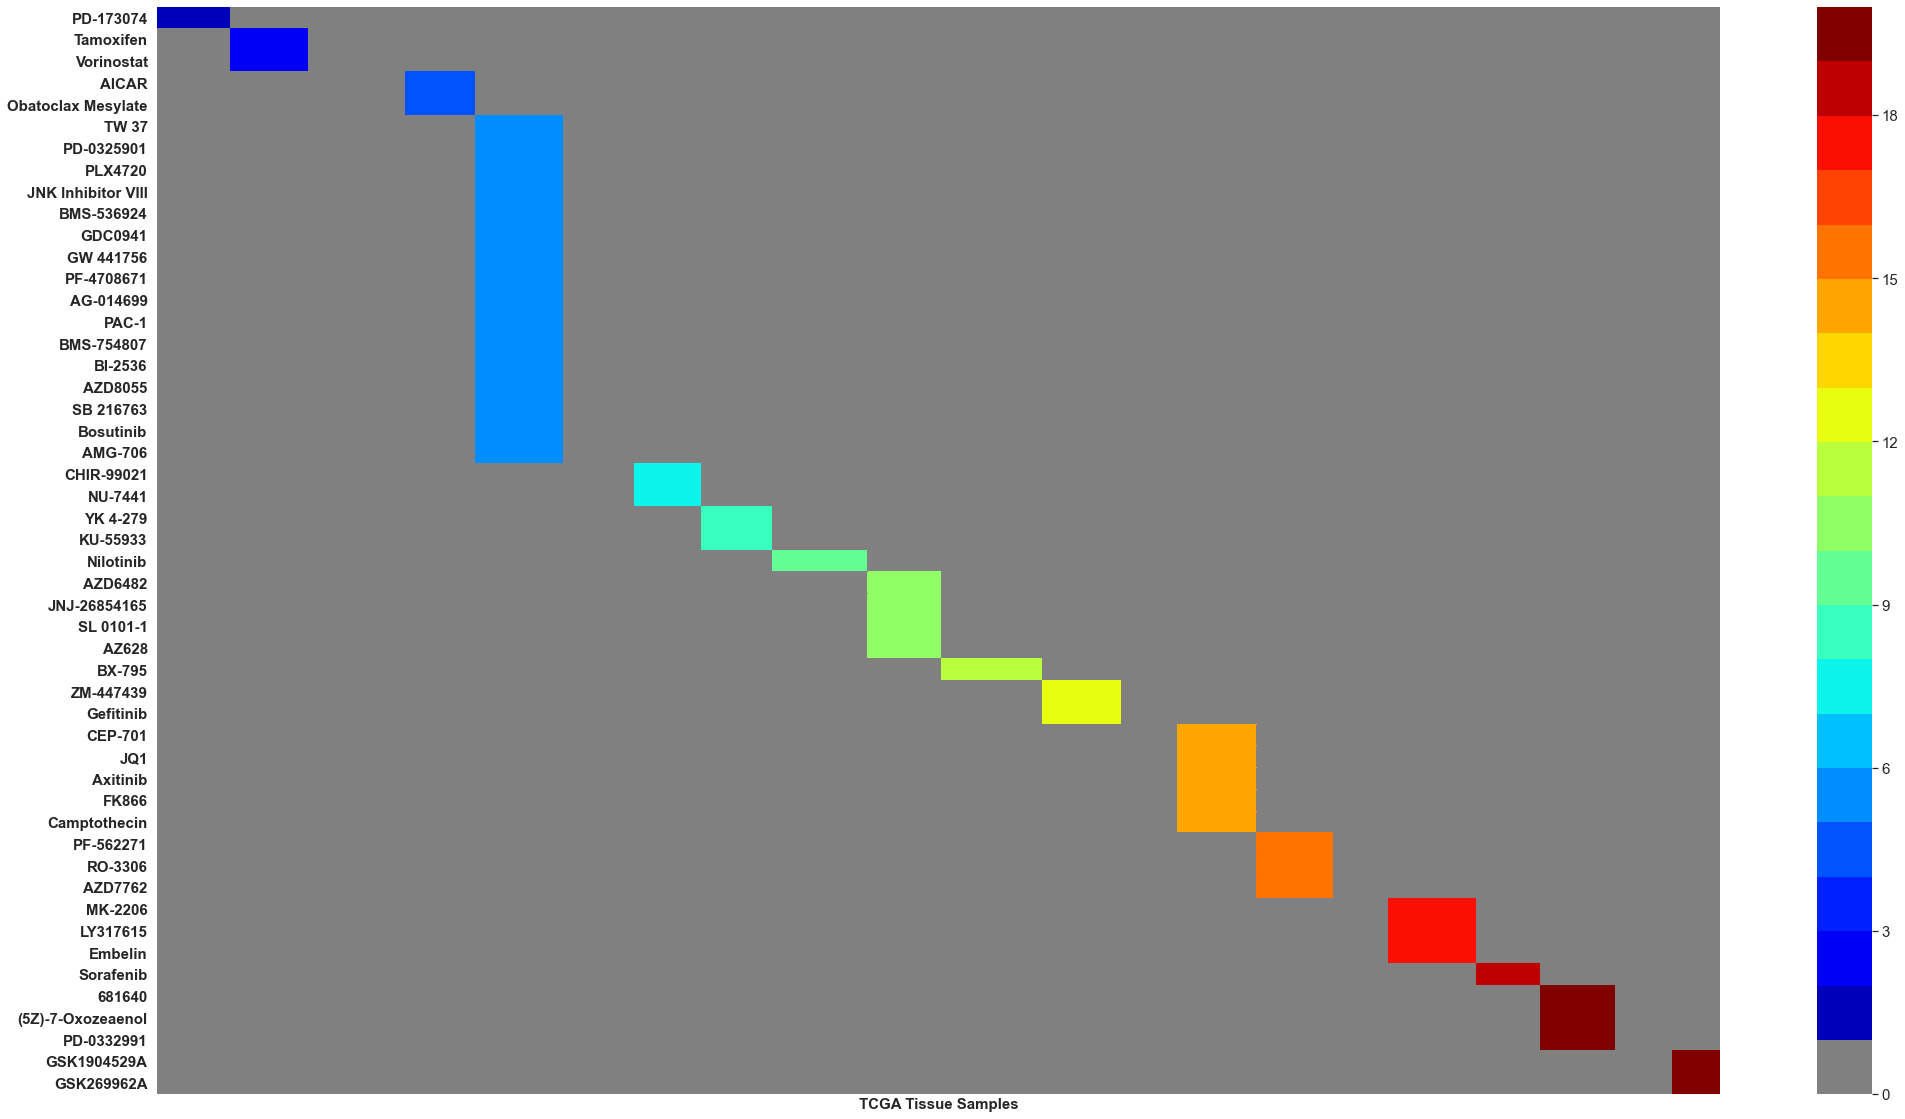

In [250]:
import matplotlib as mpl

cmap = plt.cm.jet  # define the colormap
cmaplist = [cmap(i) for i in range(cmap.N)]
cmaplist[0] = (.5, .5, .5, 1.0)

# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
bounds = np.linspace(0,num_clusters-1,num_clusters)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
plt.figure(figsize=(35,20))
plt.rcParams["ytick.labelsize"] = 15

ax = sns.heatmap(fit_data_mask.transpose(), cmap=cmap, norm=norm)
plt.xlabel("TCGA Tissue Samples", fontsize=15,weight='bold')
plt.yticks(fontsize=15, weight='bold')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
#plt.savefig(f'../intermediate_results/tcga_prediction/bi_cluster/bi_cluster_label.png', format='png', dpi=350,bbox_inches='tight')


### k-means++ clustering on TCGA samples

In [123]:
kmeans = KMeans(init="k-means++", n_clusters=33, n_init=4,
                random_state=0)


In [124]:
kmeans.fit(score_df_mat)


KMeans(n_clusters=33, n_init=4, random_state=0)

In [129]:
# for i in range(33):
#     print(f'Cluster_{i}: ')
#     row_index = np.where(kmeans.labels_==i)
#     tcga_sample = score_df_mat.index[row_index]
#     val_counts = score_df.locintermediate_results[tcga_sample,'_primary_disease'].value_counts()
#     score_means = score_df_mat.loc[tcga_sample].mean(axis=0)
#     pd.DataFrame(val_counts).to_csv(f'../intermediate_results/tcga_prediction/cluster/Cluster_{i}_tissue_counts.csv', index_label='Tissue')
#     pd.DataFrame(score_means, columns=['mean_val']).to_csv(f'../intermediate_results/tcga_prediction/cluster/Cluster_{i}_drug_means.csv', index_label='Drug')
    

### Drug Target gene expression differences

In [133]:
def aggregate_features(df):
    if any(df.columns.duplicated()):
        print('Feature Aggregating')
        df = df.transpose().groupby(level=0).mean().transpose()            
    return df

def align_feature(df1, df2):
    matched_features = list(set(df1.columns.tolist()) & set(df2.columns.tolist()))
    matched_features.sort()
    print('Aligned dataframes have {} features in common'.format(len(matched_features)))
    return df1[matched_features], df2[matched_features]

In [168]:
raw_xena_gex = pd.read_csv('../data/preprocessed_dat/xena_gex.csv', index_col=0)
hgnc_check_df = pd.read_csv('../data/hgnc-symbol-check.csv', index_col=0)
hgnc_name_mapping_dict = hgnc_check_df['Approved symbol'].to_dict()
raw_xena_gex.drop(columns=[col for col in raw_xena_gex.columns if col not in hgnc_check_df.index], inplace=True)
raw_xena_gex.columns = raw_xena_gex.columns.map(hgnc_name_mapping_dict)
raw_xena_gex = aggregate_features(raw_xena_gex)


Feature Aggregating


In [169]:
gex_df = np.log2((np.exp(raw_xena_gex)-1).transpose().groupby(level=0).sum().transpose()+1)


In [255]:
drug_info_target = pd.read_csv('../intermediate_results/tcga_prediction/drug_target_info.csv', index_col=0)
drug_info_target['Target']=drug_info_target.Target.map(hgnc_name_mapping_dict)

In [256]:
p_vals_dict = defaultdict(list)
target_genes = gex_df.columns.intersection(drug_info_target.Target)
drug_info_target = drug_info_target.reset_index().drop_duplicates().set_index('Drug')
score_df = score_df.loc[score_df.index.intersection(gex_df.index)]


In [257]:
for row in drug_info_target.iterrows():
    drug = row[0]
    target = row[1]['Target']
    top_5_threshold = score_df[drug].quantile(0.95)
    bottom_5_threshold = score_df[drug].quantile(0.05)

    pos_indexes = score_df.index[score_df[drug] >= top_5_threshold]
    neg_indexes = score_df.index[score_df[drug] <= bottom_5_threshold] 

    pos_gex = gex_df.loc[pos_indexes, [target]]
    neg_gex = gex_df.loc[neg_indexes, [target]]
    
    p_val = ttest_ind(a=pos_gex, b=neg_gex).pvalue[0]
    
    p_vals_dict['drug'].append(drug)
    p_vals_dict['target'].append(target)
    p_vals_dict['p_val'].append(p_val)
    
    p_vals_dict['responsive_avg'].append(pos_gex[target].mean())
    p_vals_dict['resistant_avg'].append(neg_gex[target].mean())


In [258]:
pd.DataFrame.from_dict(p_vals_dict).to_csv('../intermediate_results/tcga_prediction/tcga_gex/p_vals.csv', index=False)


In [259]:
p_val_df = pd.read_csv('../intermediate_results/tcga_prediction/tcga_gex/p_vals.csv', index_col=0)
p_val_df.sort_values('p_val', inplace=True)
drug_target_dict = {}
for row in p_val_df.iterrows():
    drug = row[0]
    target = row[1]['target']
    if drug not in drug_target_dict:
        drug_target_dict[drug] = target

In [260]:
p_val_df

,target,p_val,responsive_avg,resistant_avg
drug,,,,
AMG-706,PDGFRB,6.913272e-231,3.364466,6.037870
Sorafenib,PDGFRB,2.297327e-222,2.612922,5.689339
AZD7762,CHEK1,1.699350e-185,4.189527,2.204530
Axitinib,PDGFRB,3.986761e-184,3.733051,6.144508
PAC-1,CASP7,1.489685e-173,3.391790,5.062734
...,...,...,...,...
BX-795,PDK1,3.724891e-01,2.880583,2.936924
Axitinib,KIT,4.484838e-01,2.402344,2.485303
JQ1,BRD2,5.478273e-01,3.744315,3.763943


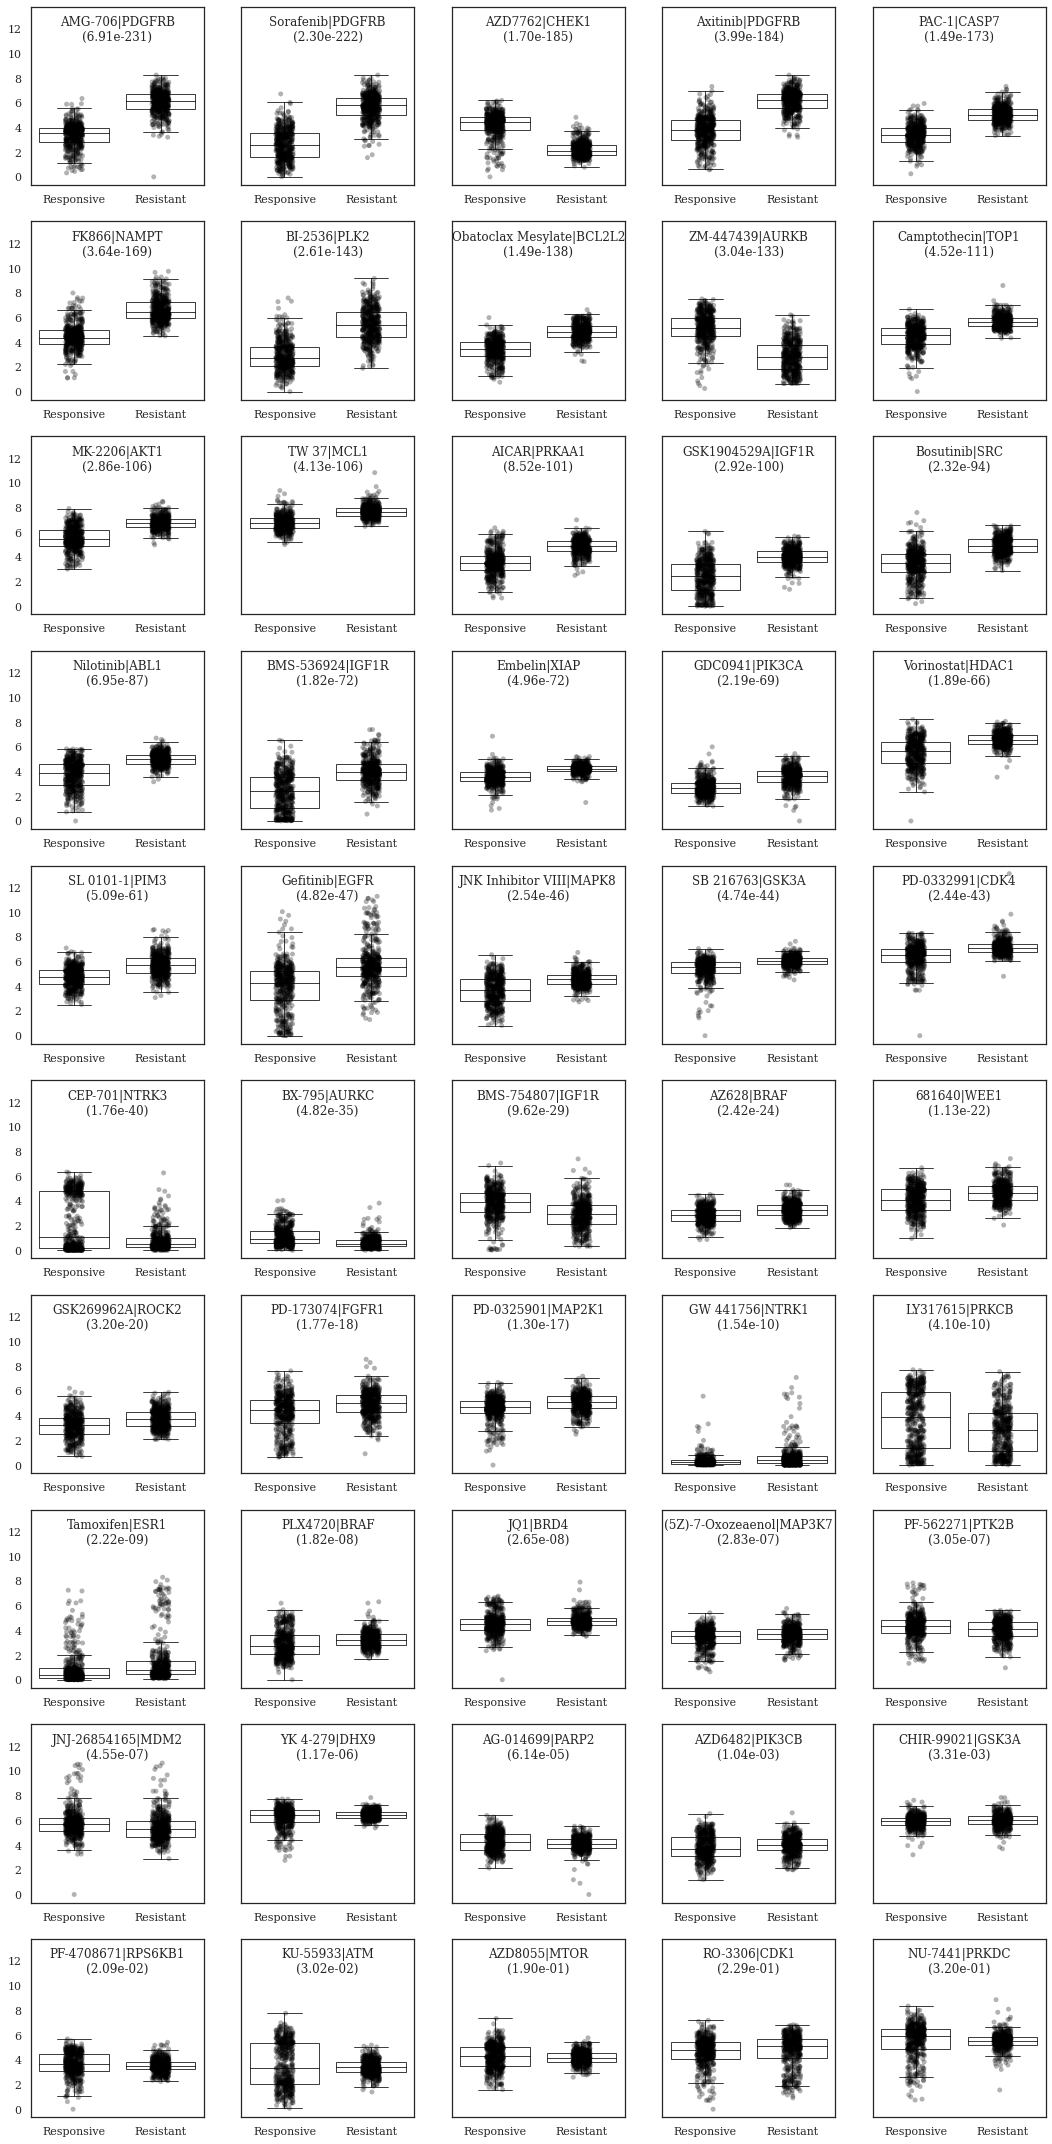

In [188]:
count = 0
sns.set(font_scale = 1.0)
sns.set_style('white', {'font.family':'serif', 'font.serif':'Times New Roman'})

fig, axes = plt.subplots(10, 5, sharey=True, figsize=(15,30))
fig.tight_layout()

for drug, target in drug_target_dict.items():
    top_5_threshold = score_df[drug].quantile(0.95)
    bottom_5_threshold = score_df[drug].quantile(0.05)

    pos_indexes = score_df.index[score_df[drug] >= top_5_threshold]
    neg_indexes = score_df.index[score_df[drug] <= bottom_5_threshold] 
    #print(f'{drug}: {target}')

    pos_gex = gex_df.loc[pos_indexes, [target]]
    neg_gex = gex_df.loc[neg_indexes, [target]]
    p_val = ttest_ind(a=pos_gex, b=neg_gex).pvalue[0]
    #print(p_val)
    
    p_vals_dict['drug'].append(drug)
    p_vals_dict['target'].append(target)
    p_vals_dict['p_val'].append(p_val)
    p_vals_dict['responsive_avg'].append(pos_gex[target].mean())
    p_vals_dict['resistant_avg'].append(neg_gex[target].mean())

    pos_gex['type'] = 'Responsive'
    neg_gex['type'] = 'Resistant'

    gex = pd.concat([pos_gex, neg_gex])
    
    ax_row = count // 5
    ax_col = count % 5
    
    sns.boxplot(ax=axes[ax_row, ax_col], x="type", y=target, data=gex, showfliers=False,
            linewidth=0.75,**PROPS)
    sns.stripplot(x="type", y=target, color='black',alpha=0.3, data=gex,ax=axes[ax_row, ax_col])
    axes[ax_row, ax_col].text(0.5, 0.95, 
        f'{drug}|{target}\n({p_val:.2e})',
        horizontalalignment='center',
        verticalalignment='top',
        transform=axes[ax_row, ax_col].transAxes)
    #axes[ax_row, ax_col].set_subtitle(f'{drug}|{target}:{p_val:.2e}')
    axes[ax_row, ax_col].set_xlabel('')
    axes[ax_row, ax_col].set_ylabel('')

    count += 1
    
#fig.savefig(f'../intermediate_results/tcga_prediction/tcga_gex/drug_p_vals.png', format='png', dpi=350,bbox_inches='tight')


AMG-706: KDR
2.192933314289239e-46
Axitinib: KDR
1.3773384055488992e-24
Sorafenib: KDR
5.653889230784166e-58
AMG-706: PDGFRB
6.913271706123257e-231
Axitinib: PDGFRB
3.98676081043872e-184
Sorafenib: PDGFRB
2.2973268488420827e-222


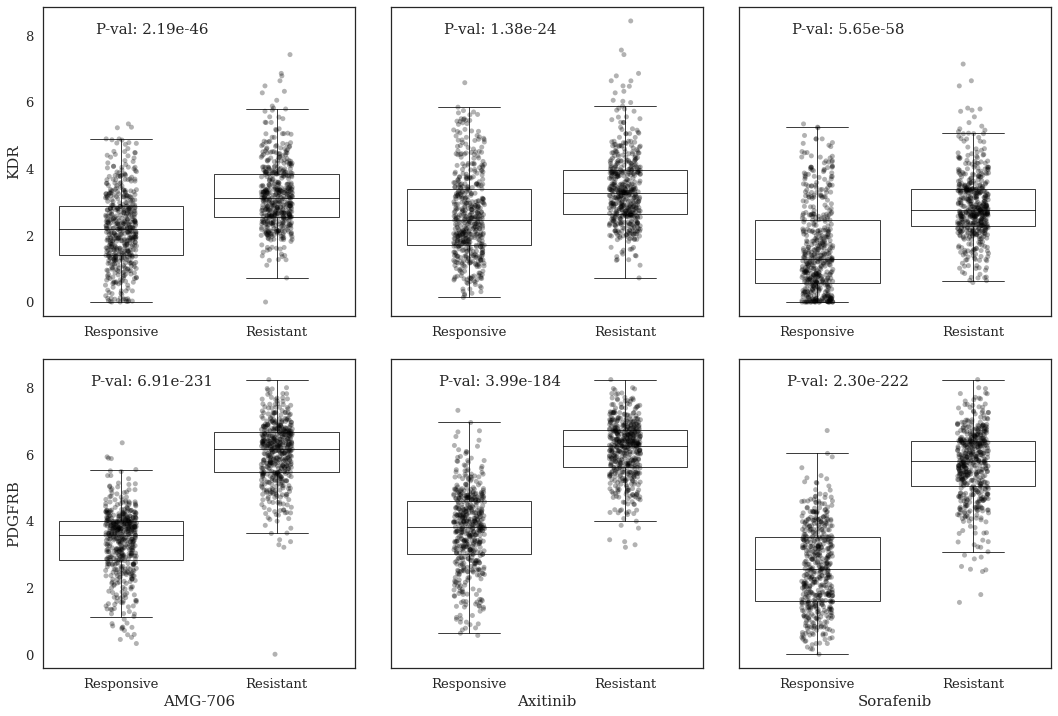

In [189]:
target_list = ['KDR', 'PDGFRB']
drug_list = ['AMG-706', 'Axitinib', 'Sorafenib']
sns.set(font_scale = 1.2)
count = 0
sns.set_style('white', {'font.family':'serif', 'font.serif':'Times New Roman'})

fig, axes = plt.subplots(2, 3, sharey=True, figsize=(15,10))
fig.tight_layout()

for target in target_list:
    for drug in drug_list:
        top_5_threshold = score_df[drug].quantile(0.95)
        bottom_5_threshold = score_df[drug].quantile(0.05)

        pos_indexes = score_df.index[score_df[drug] >= top_5_threshold]
        neg_indexes = score_df.index[score_df[drug] <= bottom_5_threshold] 
        print(f'{drug}: {target}')

        pos_gex = gex_df.loc[pos_indexes, [target]]
        neg_gex = gex_df.loc[neg_indexes, [target]]
        p_val = ttest_ind(a=pos_gex, b=neg_gex).pvalue[0]
        print(p_val)
    
        pos_gex['type'] = 'Responsive'
        neg_gex['type'] = 'Resistant'

        gex = pd.concat([pos_gex, neg_gex])
    
        ax_row = count // 3
        ax_col = count % 3
    
        sns.boxplot(ax=axes[ax_row, ax_col], x="type", y=target, data=gex, showfliers=False,
            linewidth=0.75,**PROPS)
        sns.stripplot(x="type", y=target, color='black',alpha=0.3, data=gex,ax=axes[ax_row, ax_col])

        axes[ax_row, ax_col].text(0.35, 0.95, 
            f'P-val: {p_val:.2e}',
            horizontalalignment='center',
            verticalalignment='top',
            transform=axes[ax_row, ax_col].transAxes,fontsize=15)
        if ax_row > 0:
            axes[ax_row, ax_col].set_xlabel(drug, size=15)
        else:
            axes[ax_row, ax_col].set_xlabel("")
        if ax_col > 0:
            axes[ax_row, ax_col].set_ylabel('')
        else:
            axes[ax_row, ax_col].set_ylabel(target, size=15)
    
        count += 1
fig.savefig(f'../intermediate_results/tcga_prediction/tcga_gex/draft_p_vals.png', format='png', dpi=350,bbox_inches='tight')


### tSNE plots for difference features

In [192]:
tsne = manifold.TSNE(n_components=2, init='random',random_state=0)


In [201]:
ori_gex = pd.read_csv('../data/preprocessed_dat/uq1000_feature.csv', index_col=0)
gex_label = ['TCGA'] * 9808 + ['CCLE']*1305


In [202]:
ori_gex_y = tsne.fit_transform(ori_gex)

In [205]:
ori_encoder_feature_df = pd.DataFrame(ori_gex_y, columns=['x','y'])
ori_encoder_feature_df['Sample'] = gex_label

Text(0.5, 1.0, 'Original')

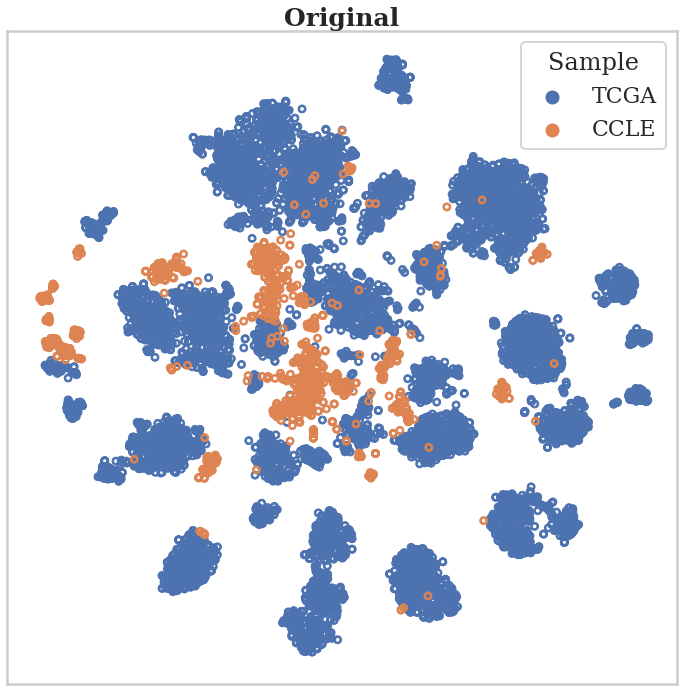

In [208]:
plt.figure(figsize=(12,12))
sns.set(font_scale = 2.0)
sns.set_context('poster')
sns.set_style('whitegrid', {'font.family':'serif', 'font.serif':'Times New Roman'})


ax = sns.scatterplot(x='x',y='y',data=ori_encoder_feature_df,hue='Sample', marker="$\circ$", ec="face")
plt.xlabel('')
plt.ylabel("")
plt.yticks([],fontsize=15, weight='bold')
plt.xticks([],fontsize=15, weight='bold')
plt.title('Original', fontsize=25, weight='bold')
#plt.savefig(f'../intermediate_results/encoded_features/Original_tSNE.png', format='png', dpi=350,bbox_inches='tight')


In [209]:
ccle_gex = pd.read_csv(f'../intermediate_results/encoded_features/ae_ccle_features.csv',index_col=0)
tcga_gex = pd.read_csv(f'../intermediate_results/encoded_features/ae_tcga_features.csv',index_col=0)
ae_all_gex = pd.concat([tcga_gex, ccle_gex])
ae_all_gex_y = tsne.fit_transform(ae_all_gex)


    

Text(0.5, 1.0, 'AE')

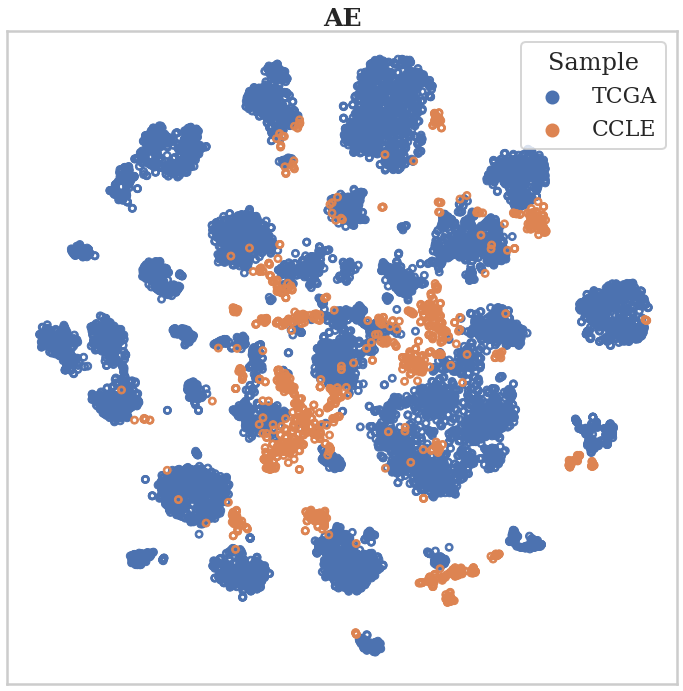

In [211]:
ae_encoder_feature_df = pd.DataFrame(ae_all_gex_y, columns=['x','y'])
ae_encoder_feature_df['Sample'] = gex_label

plt.figure(figsize=(12,12))
sns.set_context('poster')
sns.set_style('whitegrid', {'font.family':'serif', 'font.serif':'Times New Roman'})

ax = sns.scatterplot(x='x',y='y',data=ae_encoder_feature_df,hue='Sample', marker="$\circ$", ec="face")
plt.xlabel('')
plt.ylabel("")
plt.yticks([],fontsize=15, weight='bold')
plt.xticks([],fontsize=15, weight='bold')
plt.title('AE', fontsize=25, weight='bold')
#plt.savefig(f'../intermediate_results/encoded_features/AE_tSNE.png', format='png', dpi=350,bbox_inches='tight')


In [212]:
ccle_gex = pd.read_csv(f'../intermediate_results/encoded_features/codeae_ccle_features.csv',index_col=0)
tcga_gex = pd.read_csv(f'../intermediate_results/encoded_features/codeae_tcga_features.csv',index_col=0)
codeae_all_gex = pd.concat([tcga_gex, ccle_gex])
codeae_all_gex_y = tsne.fit_transform(codeae_all_gex)


    

Text(0.5, 1.0, 'AE')

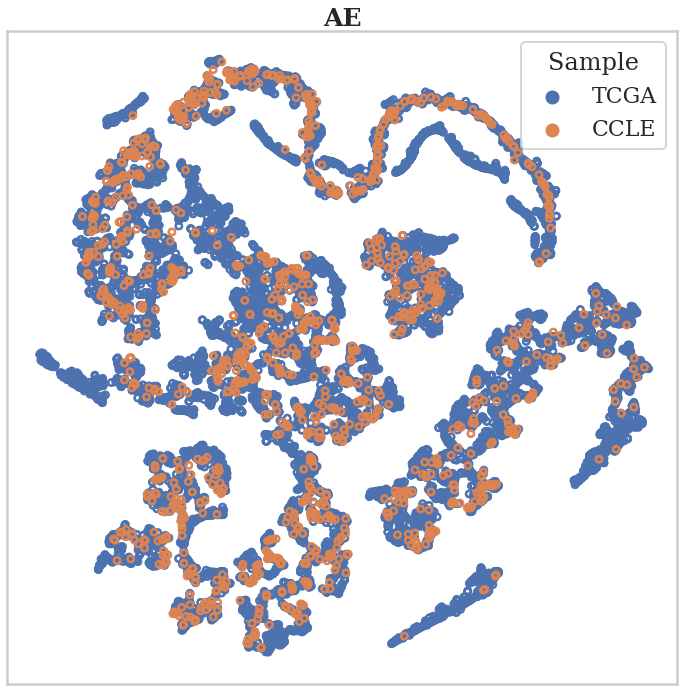

In [213]:
codeae_encoder_feature_df = pd.DataFrame(codeae_all_gex_y, columns=['x','y'])
codeae_encoder_feature_df['Sample'] = gex_label

plt.figure(figsize=(12,12))
sns.set_context('poster')
sns.set_style('whitegrid', {'font.family':'serif', 'font.serif':'Times New Roman'})

ax = sns.scatterplot(x='x',y='y',data=codeae_encoder_feature_df,hue='Sample', marker="$\circ$", ec="face")
plt.xlabel('')
plt.ylabel("")
plt.yticks([],fontsize=15, weight='bold')
plt.xticks([],fontsize=15, weight='bold')
plt.title('AE', fontsize=25, weight='bold')
#plt.savefig(f'../intermediate_results/encoded_features/CODEAE_tSNE.png', format='png', dpi=350,bbox_inches='tight')
